In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV



import joblib
from tqdm import tqdm


## Data Loading

In [ ]:
train_fares_df = pd.read_csv('/Users/deepeshdwivedi/Documents/personal docs/United Airlines/training/train_fares.csv',index_col=0)
train_fares_df.head()

,origin,destination,carrier,flt_num,flt_departure_dt,observation_date,total_fare,origin_city,destination_city
1,Airport4,Airport43,L1,5911,2018-01-03,2017-11-29,538,City4,City39
2,Airport4,Airport43,L1,6589,2018-01-03,2017-11-29,538,City4,City39
3,Airport4,Airport43,L1,2689,2018-01-03,2017-11-29,538,City4,City39
4,Airport4,Airport43,L2,8244,2018-01-03,2017-11-29,557,City4,City39
5,Airport4,Airport43,L2,8523,2018-01-03,2017-11-29,557,City4,City39


In [ ]:
train_schedules_df = pd.read_csv('/Users/deepeshdwivedi/Documents/personal docs/United Airlines/training/train_schedules.csv',index_col=0)
train_schedules_df.head()

,carrier,flt_num,origin,destination,flt_departure_dt,flt_departure_local_time,flt_arrival_local_time,flt_departure_gmt,flt_arrival_gmt
1,L1,6800,Airport26,Airport30,2018-02-01,2018-02-01 18:43:00.0,2018-02-01 20:09:00.0,2018-02-02 00:43:00.0,2018-02-02 04:09:00.0
2,OTH,783,Airport26,Airport30,2018-02-01,2018-02-01 19:45:00.0,2018-02-01 21:05:00.0,2018-02-02 01:45:00.0,2018-02-02 05:05:00.0
3,L1,799,Airport26,Airport30,2018-02-01,2018-02-01 12:00:00.0,2018-02-01 13:26:00.0,2018-02-01 18:00:00.0,2018-02-01 21:26:00.0
4,L1,7760,Airport26,Airport30,2018-02-01,2018-02-01 07:35:00.0,2018-02-01 09:02:00.0,2018-02-01 13:35:00.0,2018-02-01 17:02:00.0
5,L1,3443,Airport26,Airport30,2018-02-01,2018-02-01 09:48:00.0,2018-02-01 11:14:00.0,2018-02-01 15:48:00.0,2018-02-01 19:14:00.0


In [ ]:
service_index_df = pd.read_csv('/Users/deepeshdwivedi/Documents/personal docs/United Airlines/training/service_index.csv',index_col=0)
service_index_df.head()

,yr,mo,origin,destination,carrier,scaled_demand,scaled_share
1,2017,12,Airport10,Airport31,U2,2820,160
2,2017,12,Airport10,Airport43,L3,1708,169
3,2017,12,Airport10,Airport60,L2,1071,180
4,2017,12,Airport16,Airport60,U1,1633,160
5,2017,12,Airport17,Airport1,OTH,988,275


## Exploratory Data Analysis

### Fare Analysis

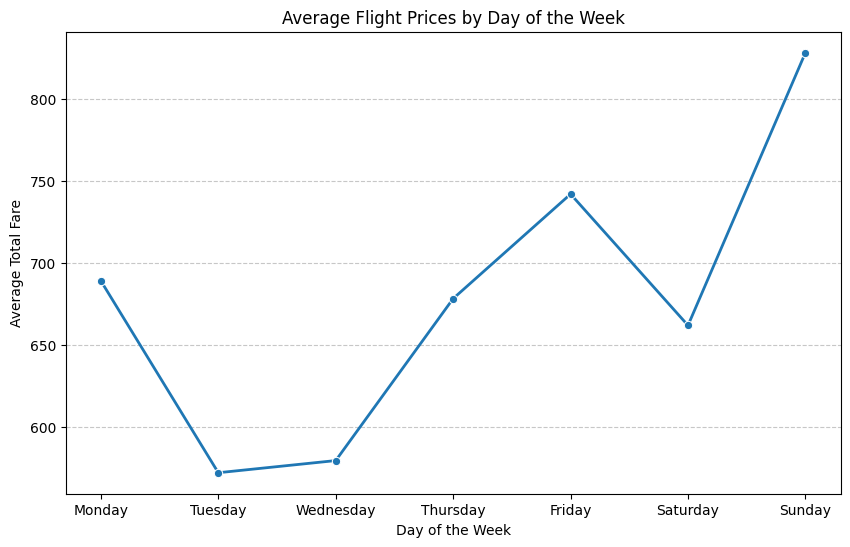

In [ ]:


# Calculate the average fare per weekday
weekday_fares = train_fares_df.groupby('departure_weekday')['total_fare'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Line Plot
plt.figure(figsize=(10,6))
sns.lineplot(x=weekday_fares.index, y=weekday_fares.values, marker='o', linewidth=2)
plt.title("Average Flight Prices by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Total Fare")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


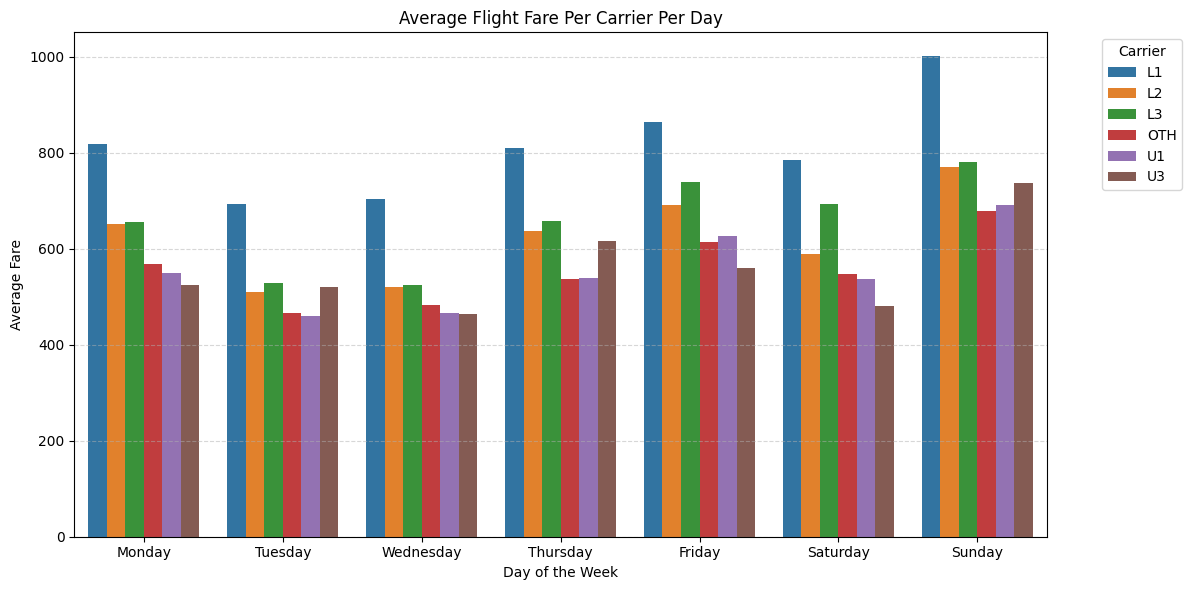

In [ ]:
# Compute the average fare per carrier per weekday
carrier_weekday_fares = train_fares_df.groupby(['carrier', 'departure_weekday'])['total_fare'].mean().reset_index()

# Sort the weekdays in correct order
carrier_weekday_fares['departure_weekday'] = pd.Categorical(
    carrier_weekday_fares['departure_weekday'],
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)

# Plot the grouped bar chart
plt.figure(figsize=(12,6))
ax = sns.barplot(x='departure_weekday', y='total_fare', hue='carrier', data=carrier_weekday_fares)

# Move the legend outside
plt.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')

# Titles and Labels
plt.title("Average Flight Fare Per Carrier Per Day")
plt.xlabel("Day of the Week")
plt.ylabel("Average Fare")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()


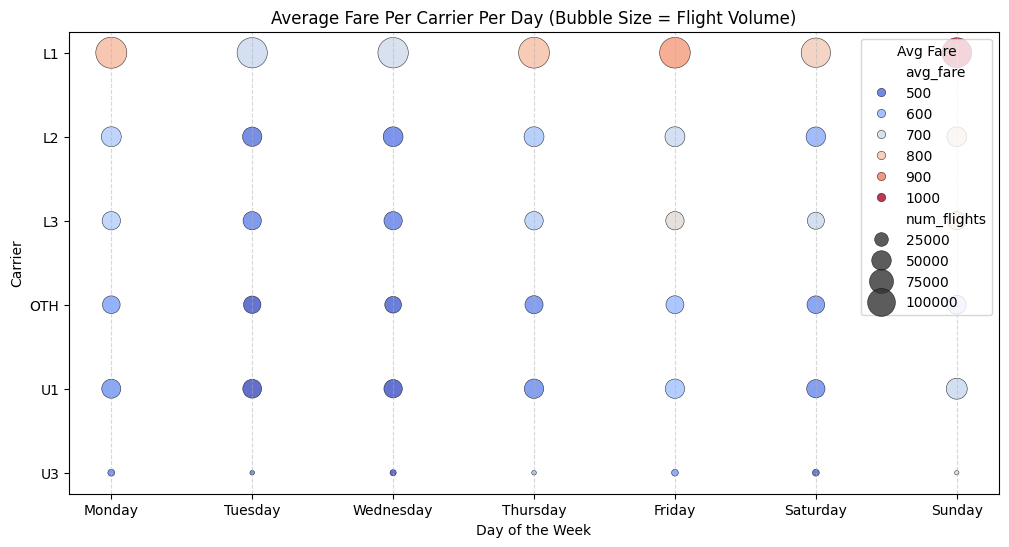

In [ ]:
# Compute average fare and count of flights per carrier per weekday
bubble_data = train_fares_df.groupby(['carrier', 'departure_weekday']).agg(
    avg_fare=('total_fare', 'mean'),
    num_flights=('total_fare', 'count')
).reset_index()

# Sort weekdays in correct order
bubble_data['departure_weekday'] = pd.Categorical(
    bubble_data['departure_weekday'],
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)

# Bubble Plot
plt.figure(figsize=(12,6))
sns.scatterplot(
    x='departure_weekday', y='carrier', size='num_flights', hue='avg_fare',
    data=bubble_data, sizes=(10, 500), palette="coolwarm", edgecolor="black", alpha=0.8
)
plt.title("Average Fare Per Carrier Per Day (Bubble Size = Flight Volume)")
plt.xlabel("Day of the Week")
plt.ylabel("Carrier")
plt.legend(title="Avg Fare")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


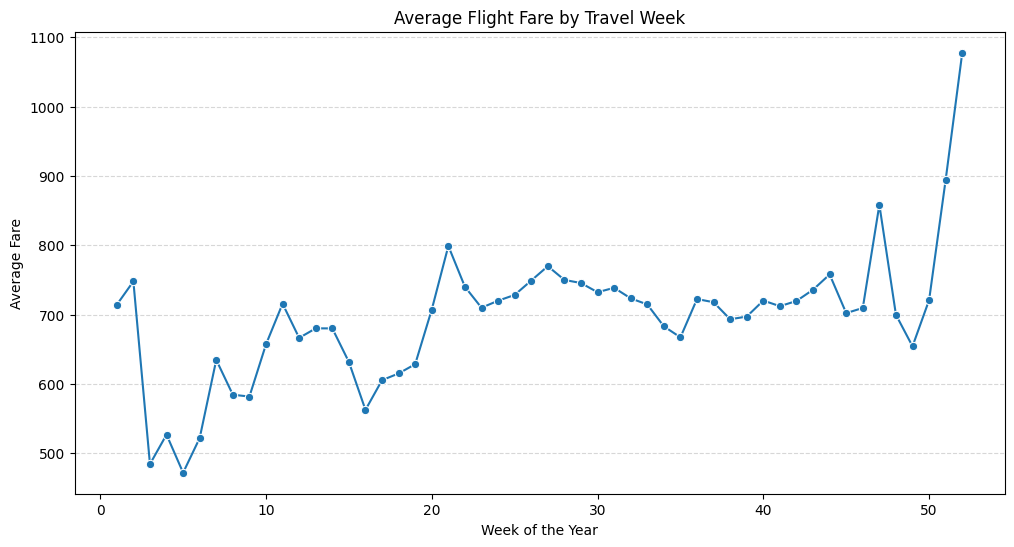

In [ ]:

# Compute average fare per travel week
weekly_fare_trend = train_fares_df.groupby('travel_week')['total_fare'].mean().reset_index()

# Plot Line Chart
plt.figure(figsize=(12,6))
sns.lineplot(x='travel_week', y='total_fare', data=weekly_fare_trend, marker='o')
plt.title("Average Flight Fare by Travel Week")
plt.xlabel("Week of the Year")
plt.ylabel("Average Fare")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


/var/folders/cq/zrrjq02s1hq2p31y3d6tbfm80000gn/T/ipykernel_6867/2056731722.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_holiday', y='total_fare', data=holiday_fares, palette="coolwarm")


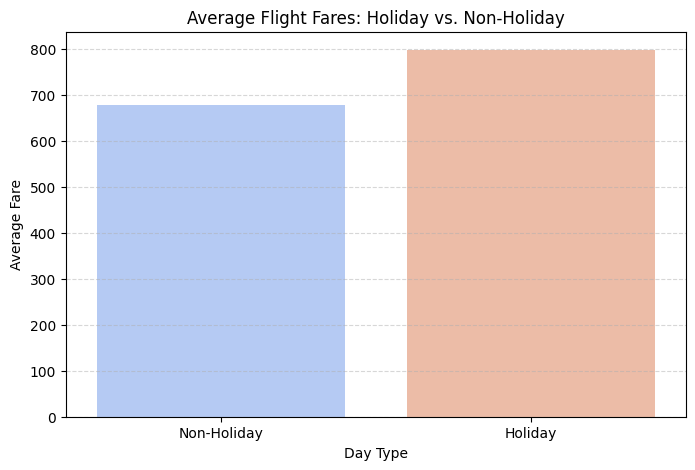

In [ ]:
# Compute average fare for holiday vs. non-holiday flights
holiday_fares = train_fares_df.groupby('is_holiday')['total_fare'].mean().reset_index()
holiday_fares['is_holiday'] = holiday_fares['is_holiday'].map({0: 'Non-Holiday', 1: 'Holiday'})

# Plot bar chart
plt.figure(figsize=(8,5))
sns.barplot(x='is_holiday', y='total_fare', data=holiday_fares, palette="coolwarm")
plt.title("Average Flight Fares: Holiday vs. Non-Holiday")
plt.xlabel("Day Type")
plt.ylabel("Average Fare")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


/var/folders/cq/zrrjq02s1hq2p31y3d6tbfm80000gn/T/ipykernel_82637/3315599460.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='total_fare', data=holiday_vs_peak, palette="coolwarm")


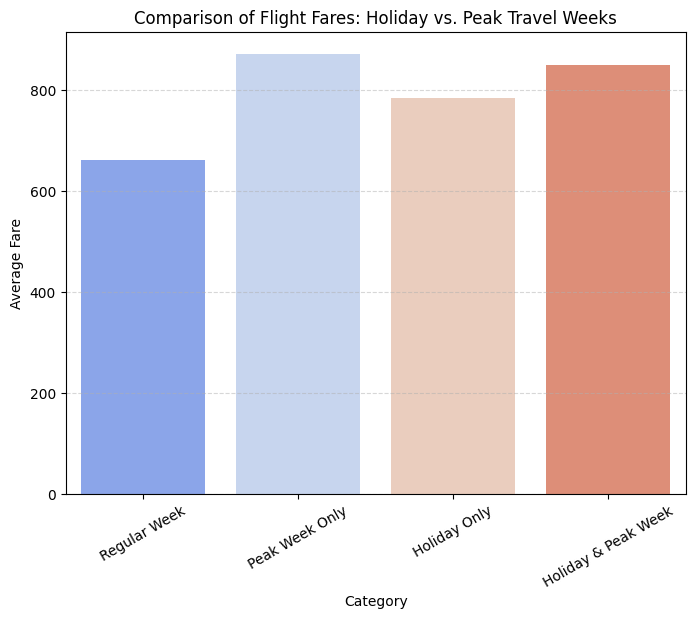

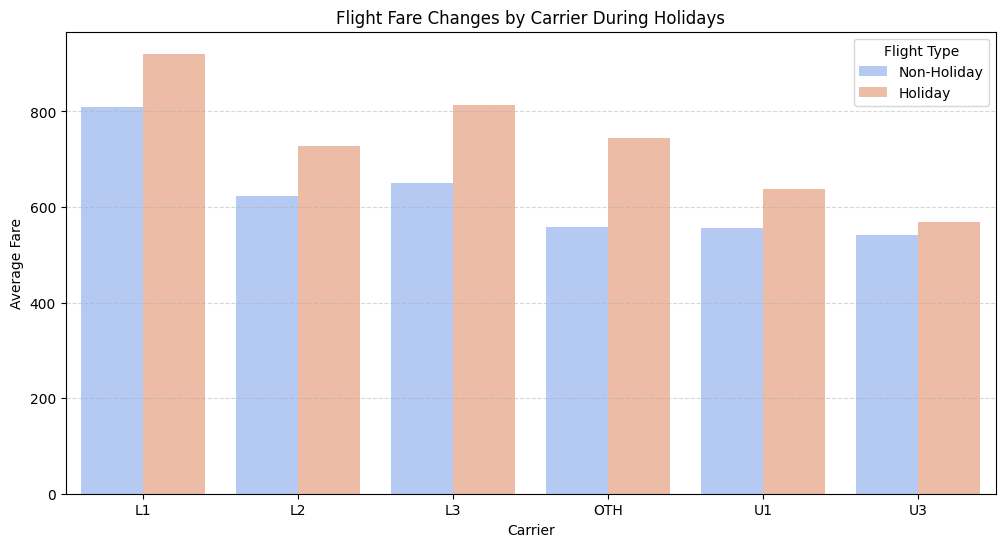

In [ ]:
# Compute average fare per travel week
weekly_fare_trend = train_fares_df.groupby('travel_week')['total_fare'].mean().reset_index()

# Identify peak travel weeks (Top 10% most expensive weeks)
top_10_percent_threshold = weekly_fare_trend['total_fare'].quantile(0.90)
peak_weeks = weekly_fare_trend[weekly_fare_trend['total_fare'] >= top_10_percent_threshold]['travel_week'].tolist()

# Create a column indicating if the travel week is a peak week
train_fares_df['is_peak_week'] = train_fares_df['travel_week'].apply(lambda x: 1 if x in peak_weeks else 0)

# Compare holiday weeks vs. peak travel weeks
holiday_vs_peak = train_fares_df.groupby(['is_holiday', 'is_peak_week'])['total_fare'].mean().reset_index()
holiday_vs_peak['Category'] = holiday_vs_peak.apply(
    lambda row: "Holiday & Peak Week" if row['is_holiday'] == 1 and row['is_peak_week'] == 1 else
                "Holiday Only" if row['is_holiday'] == 1 else
                "Peak Week Only" if row['is_peak_week'] == 1 else "Regular Week",
    axis=1
)

# Plot comparison of holiday weeks vs. peak weeks
plt.figure(figsize=(8,6))
sns.barplot(x='Category', y='total_fare', data=holiday_vs_peak, palette="coolwarm")
plt.title("Comparison of Flight Fares: Holiday vs. Peak Travel Weeks")
plt.xlabel("Category")
plt.ylabel("Average Fare")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=30)
plt.show()

# Analyzing whether certain airlines increase fares more during holidays
carrier_holiday_fares = train_fares_df.groupby(['carrier', 'is_holiday'])['total_fare'].mean().reset_index()
carrier_holiday_fares['is_holiday'] = carrier_holiday_fares['is_holiday'].map({0: 'Non-Holiday', 1: 'Holiday'})

# Plot price increase per carrier during holidays
plt.figure(figsize=(12,6))
sns.barplot(x='carrier', y='total_fare', hue='is_holiday', data=carrier_holiday_fares, palette="coolwarm")
plt.title("Flight Fare Changes by Carrier During Holidays")
plt.xlabel("Carrier")
plt.ylabel("Average Fare")
plt.legend(title="Flight Type")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

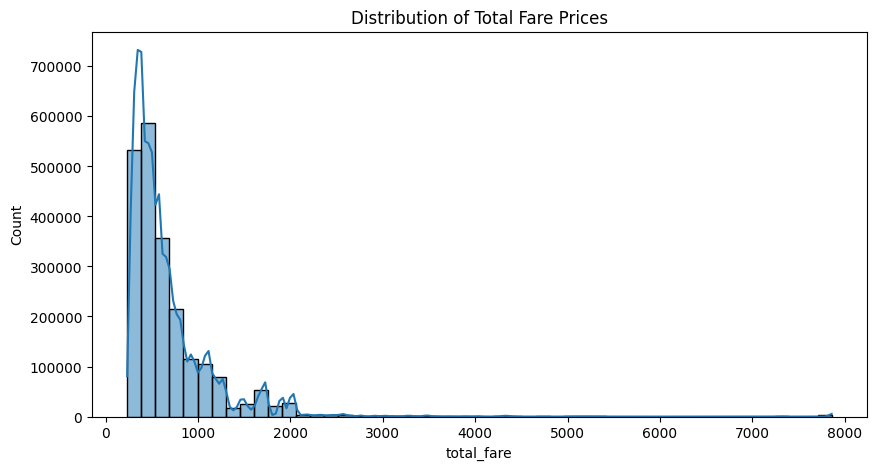

In [ ]:
# Distribution of total fares
plt.figure(figsize=(10,5))
sns.histplot(train_fares_df['total_fare'], bins=50, kde=True)
plt.title("Distribution of Total Fare Prices")
plt.show()

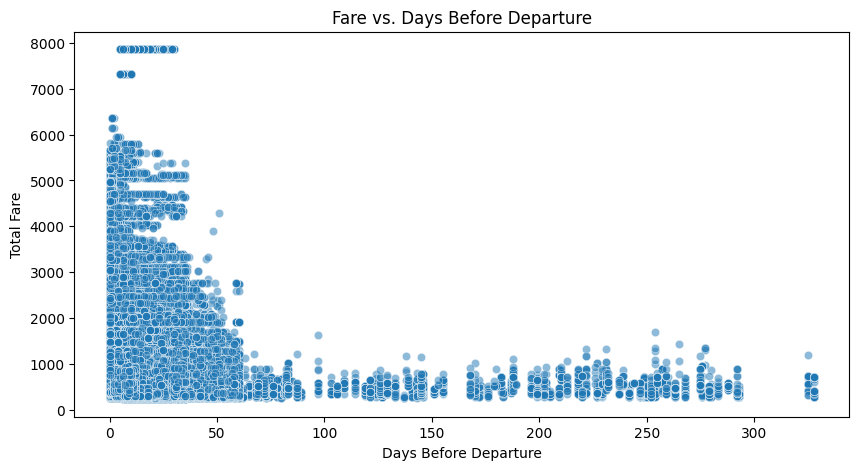

In [ ]:
train_fares_df['days_before_departure'] = (train_fares_df['flt_departure_dt'] - train_fares_df['observation_date']).dt.days

plt.figure(figsize=(10,5))
sns.scatterplot(x='days_before_departure', y='total_fare', data=train_fares_df, alpha=0.5)
plt.title("Fare vs. Days Before Departure")
plt.xlabel("Days Before Departure")
plt.ylabel("Total Fare")
plt.show()


Fares typically increase as the departure date gets closer.
A nonlinear pattern suggests airlines optimize pricing dynamically.

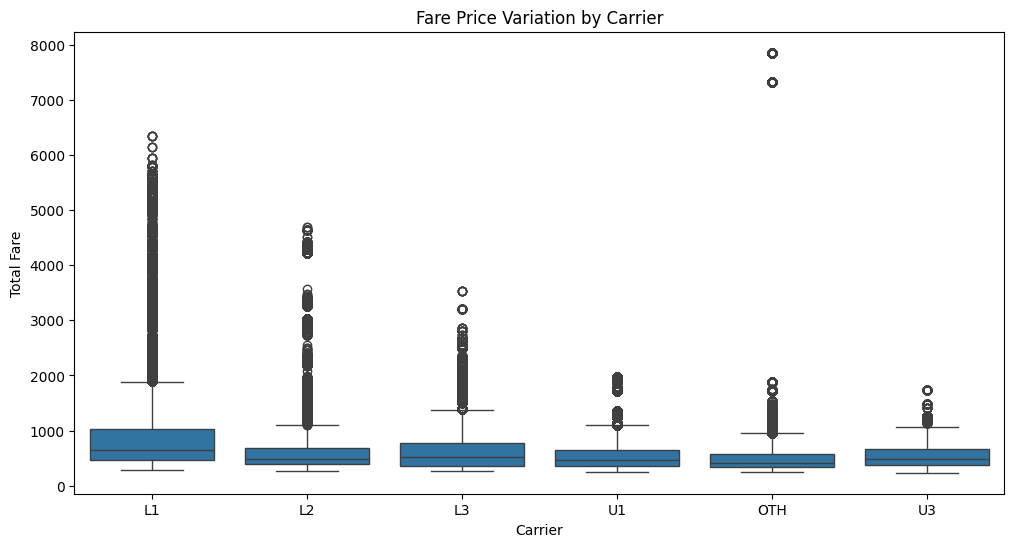

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='carrier', y='total_fare', data=train_fares_df)
plt.title("Fare Price Variation by Carrier")
plt.xlabel("Carrier")
plt.ylabel("Total Fare")
plt.show()


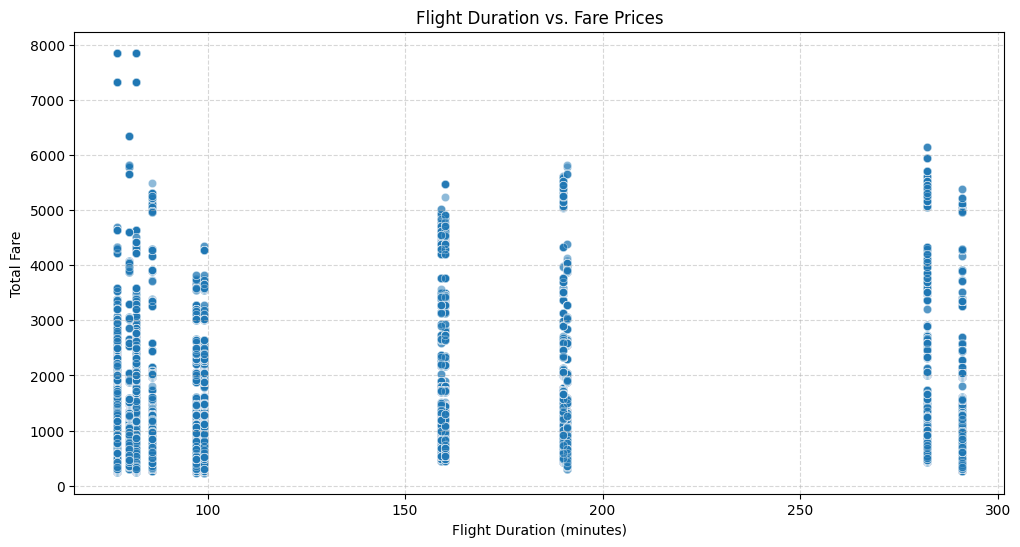

In [ ]:
# Convert necessary columns to proper data types to reduce memory usage
for col in ['origin', 'destination']:
    train_fares_df[col] = train_fares_df[col].astype('category')
    train_schedules_df[col] = train_schedules_df[col].astype('category')

# Convert flight_duration to float (if not already)
train_schedules_df['flight_duration'] = train_schedules_df['flight_duration'].astype(float)

# Drop duplicate records in train_schedules_df to avoid many-to-many merge issues
train_schedules_df = train_schedules_df.drop_duplicates(subset=['origin', 'destination'])

# Perform the optimized merge
flight_fares = train_fares_df.merge(
    train_schedules_df[['origin', 'destination', 'flight_duration']],
    on=['origin', 'destination'],
    how='left',  # Ensures we don’t lose fare records if no matching schedule is found
    validate="many_to_one"  # Helps detect accidental many-to-many merges
)

# Remove rows with missing values (if any) after merging
flight_fares = flight_fares.dropna(subset=['flight_duration'])

# Visualizing the relationship between Flight Duration & Fare Prices
plt.figure(figsize=(12,6))
sns.scatterplot(x='flight_duration', y='total_fare', data=flight_fares, alpha=0.5)
plt.title("Flight Duration vs. Fare Prices")
plt.xlabel("Flight Duration (minutes)")
plt.ylabel("Total Fare")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

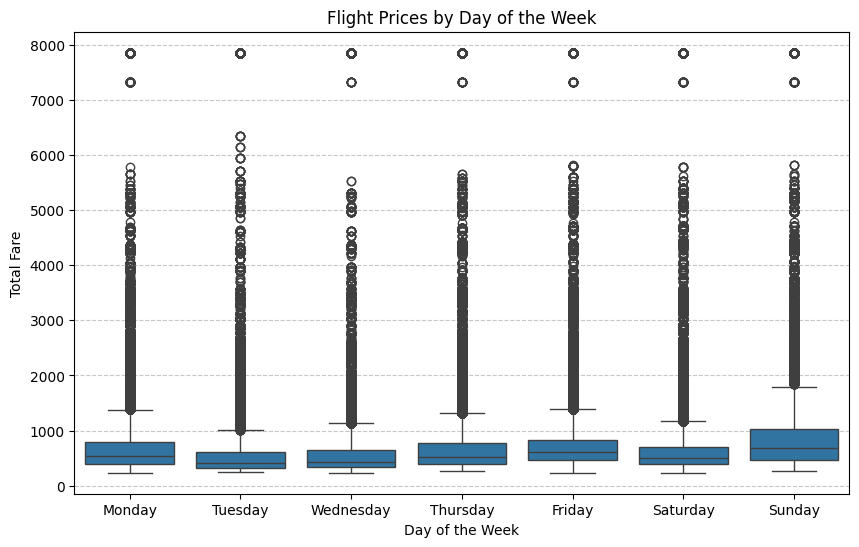

In [ ]:

plt.figure(figsize=(10,6))
sns.boxplot(x='departure_weekday', y='total_fare', data=train_fares_df, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title("Flight Prices by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Fare")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


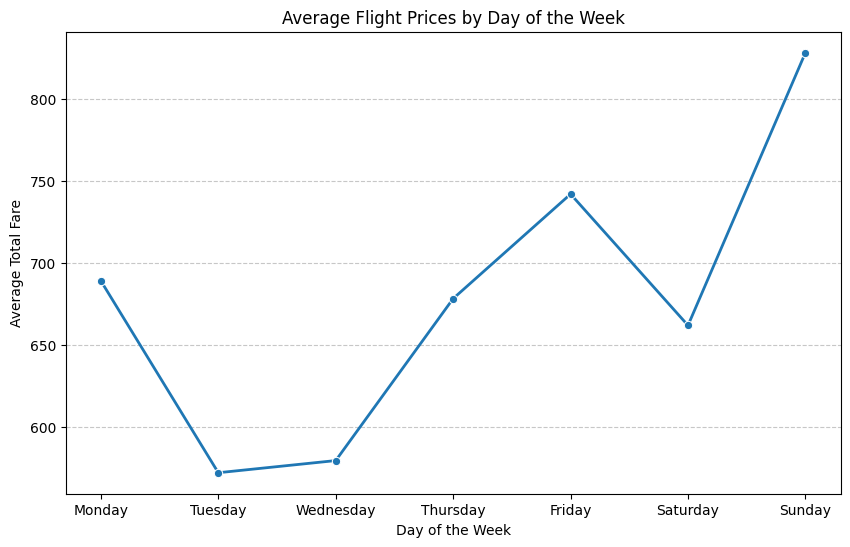

In [ ]:

# Calculate the average fare per weekday
weekday_fares = train_fares_df.groupby('departure_weekday')['total_fare'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Line Plot
plt.figure(figsize=(10,6))
sns.lineplot(x=weekday_fares.index, y=weekday_fares.values, marker='o', linewidth=2)
plt.title("Average Flight Prices by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Total Fare")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


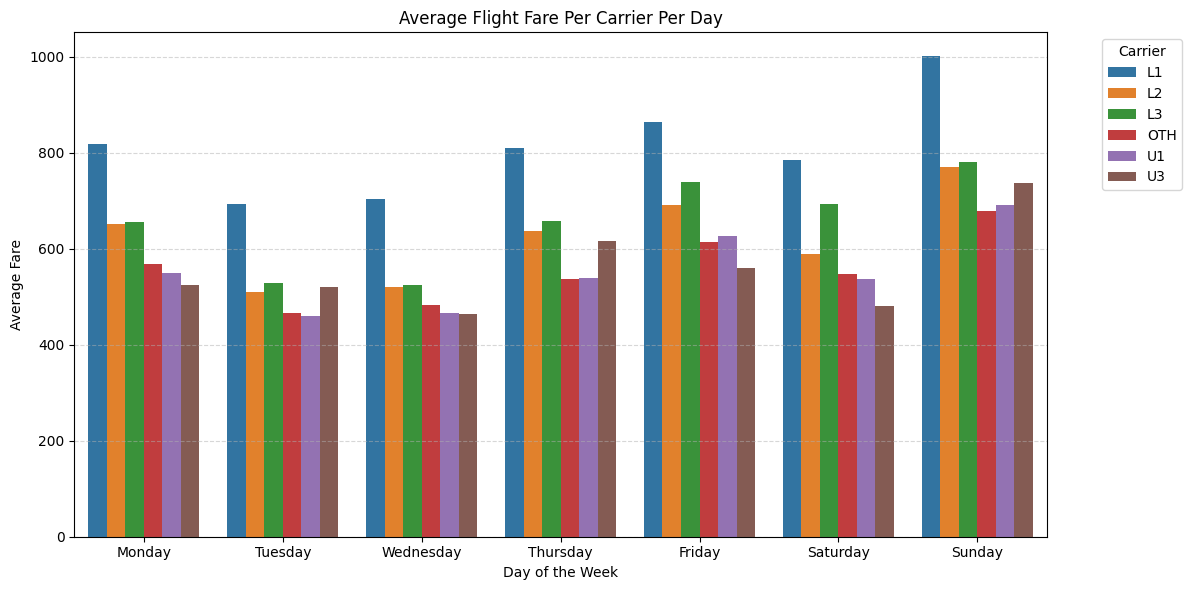

In [ ]:

# Compute the average fare per carrier per weekday
carrier_weekday_fares = train_fares_df.groupby(['carrier', 'departure_weekday'])['total_fare'].mean().reset_index()

# Sort the weekdays in correct order
carrier_weekday_fares['departure_weekday'] = pd.Categorical(
    carrier_weekday_fares['departure_weekday'],
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)

# Plot the grouped bar chart
plt.figure(figsize=(12,6))
ax = sns.barplot(x='departure_weekday', y='total_fare', hue='carrier', data=carrier_weekday_fares)

# Move the legend outside
plt.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')

# Titles and Labels
plt.title("Average Flight Fare Per Carrier Per Day")
plt.xlabel("Day of the Week")
plt.ylabel("Average Fare")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()


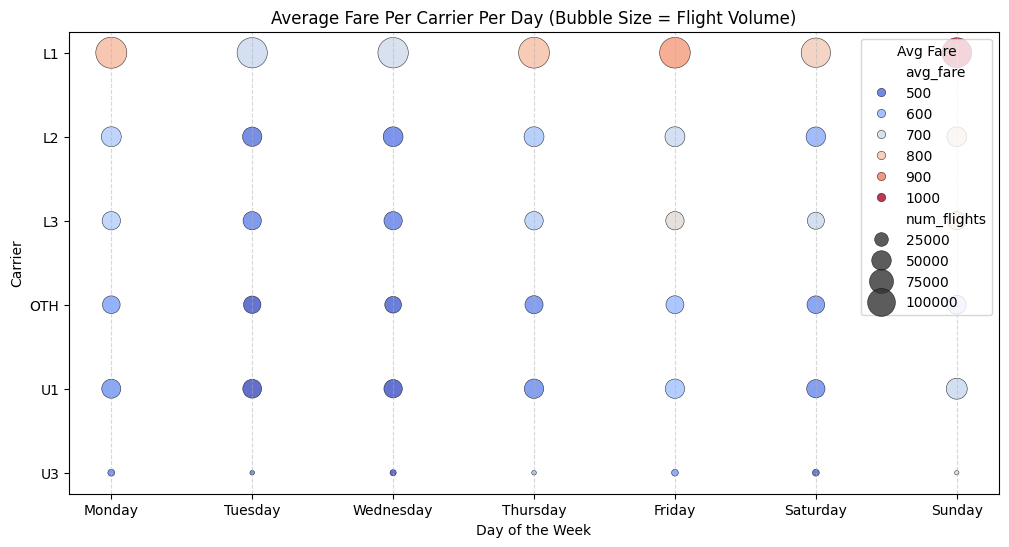

In [ ]:
# Compute average fare and count of flights per carrier per weekday
bubble_data = train_fares_df.groupby(['carrier', 'departure_weekday']).agg(
    avg_fare=('total_fare', 'mean'),
    num_flights=('total_fare', 'count')
).reset_index()

# Sort weekdays in correct order
bubble_data['departure_weekday'] = pd.Categorical(
    bubble_data['departure_weekday'],
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)

# Bubble Plot
plt.figure(figsize=(12,6))
sns.scatterplot(
    x='departure_weekday', y='carrier', size='num_flights', hue='avg_fare',
    data=bubble_data, sizes=(10, 500), palette="coolwarm", edgecolor="black", alpha=0.8
)
plt.title("Average Fare Per Carrier Per Day (Bubble Size = Flight Volume)")
plt.xlabel("Day of the Week")
plt.ylabel("Carrier")
plt.legend(title="Avg Fare")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


### Demand & Market Share Analysis

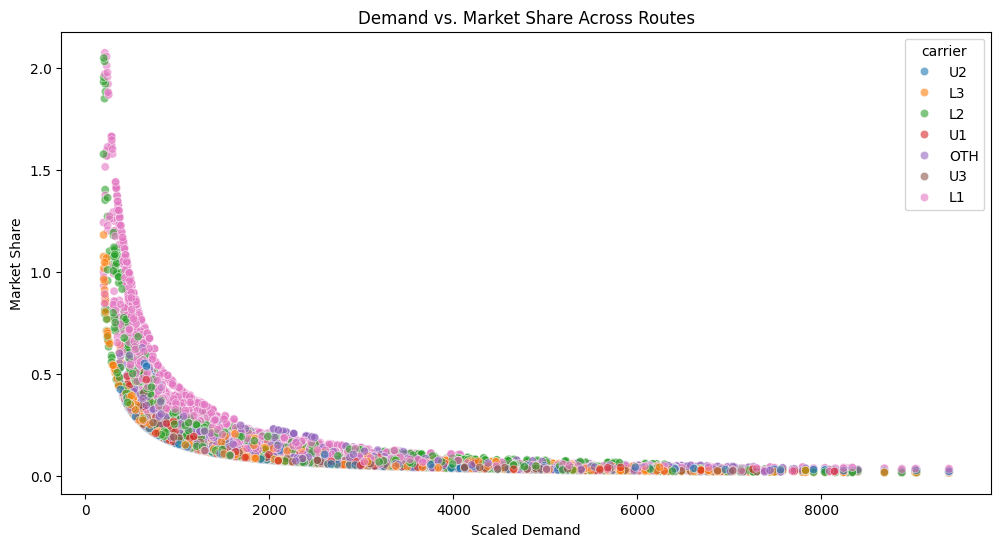

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='scaled_demand', y='market_share', hue='carrier', data=service_index_df, alpha=0.6)
plt.title("Demand vs. Market Share Across Routes")
plt.xlabel("Scaled Demand")
plt.ylabel("Market Share")
plt.show()


/var/folders/cq/zrrjq02s1hq2p31y3d6tbfm80000gn/T/ipykernel_10834/40090381.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='scaled_demand', y='route', data=top_routes, palette="coolwarm")


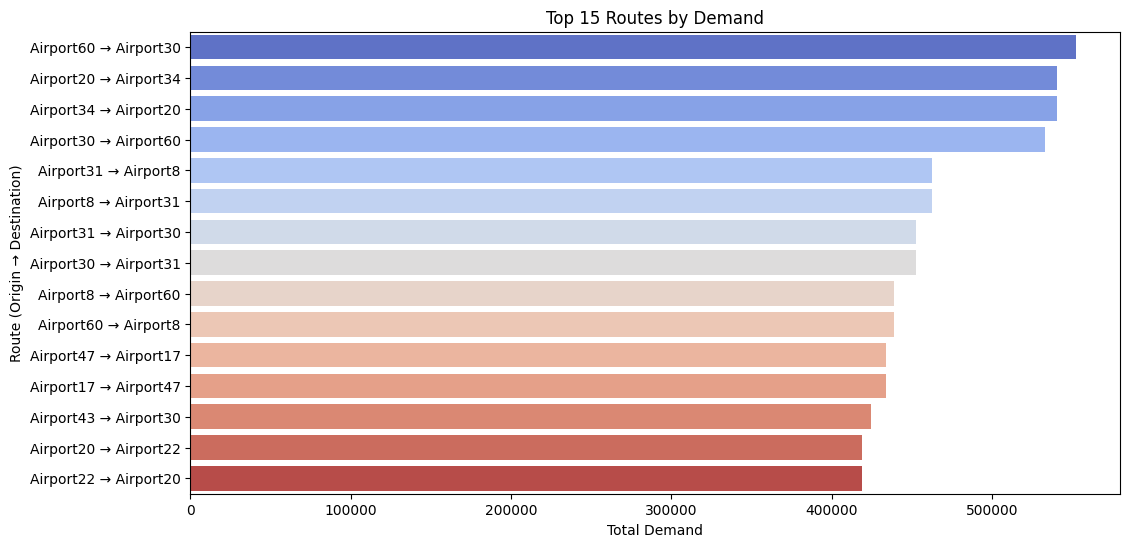

In [ ]:
# Aggregate demand per route
route_demand = service_index_df.groupby(['origin', 'destination'])['scaled_demand'].sum().reset_index()

# Sort and plot
route_demand = route_demand.sort_values('scaled_demand', ascending=False)

# Create a new column combining Origin & Destination
route_demand['route'] = route_demand['origin'] + " → " + route_demand['destination']

# Sort by demand and select top 15 routes
top_routes = route_demand.sort_values('scaled_demand', ascending=False).head(15)

# Plot with route names
plt.figure(figsize=(12,6))
sns.barplot(x='scaled_demand', y='route', data=top_routes, palette="coolwarm")

plt.title("Top 15 Routes by Demand")
plt.xlabel("Total Demand")
plt.ylabel("Route (Origin → Destination)")
plt.show()


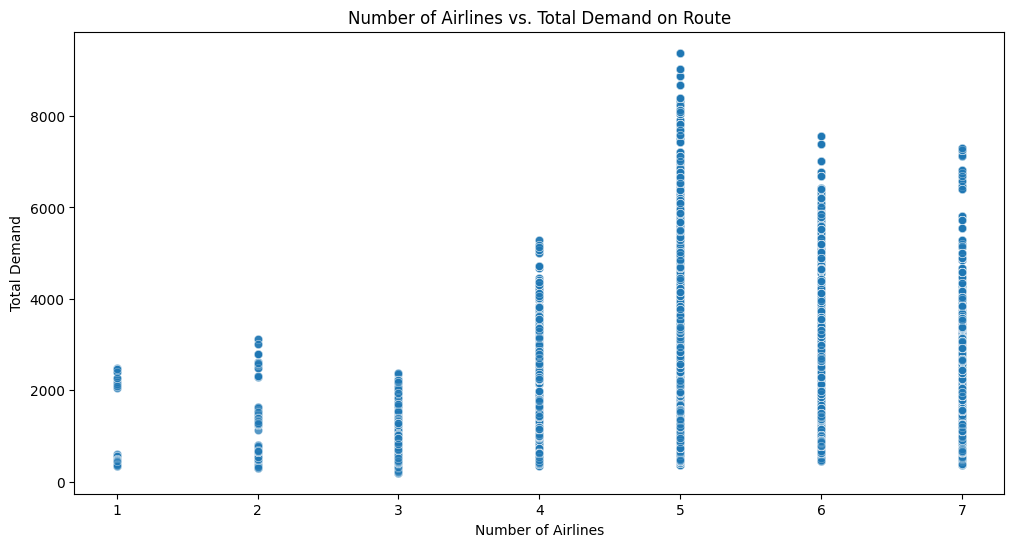

In [ ]:
# Merge airline count with demand
service_df = service_index_df.merge(route_airlines, on=['origin', 'destination'])

plt.figure(figsize=(12,6))
sns.scatterplot(x='num_airlines', y='scaled_demand', data=service_df, alpha=0.5)
plt.title("Number of Airlines vs. Total Demand on Route")
plt.xlabel("Number of Airlines")
plt.ylabel("Total Demand")
plt.show()


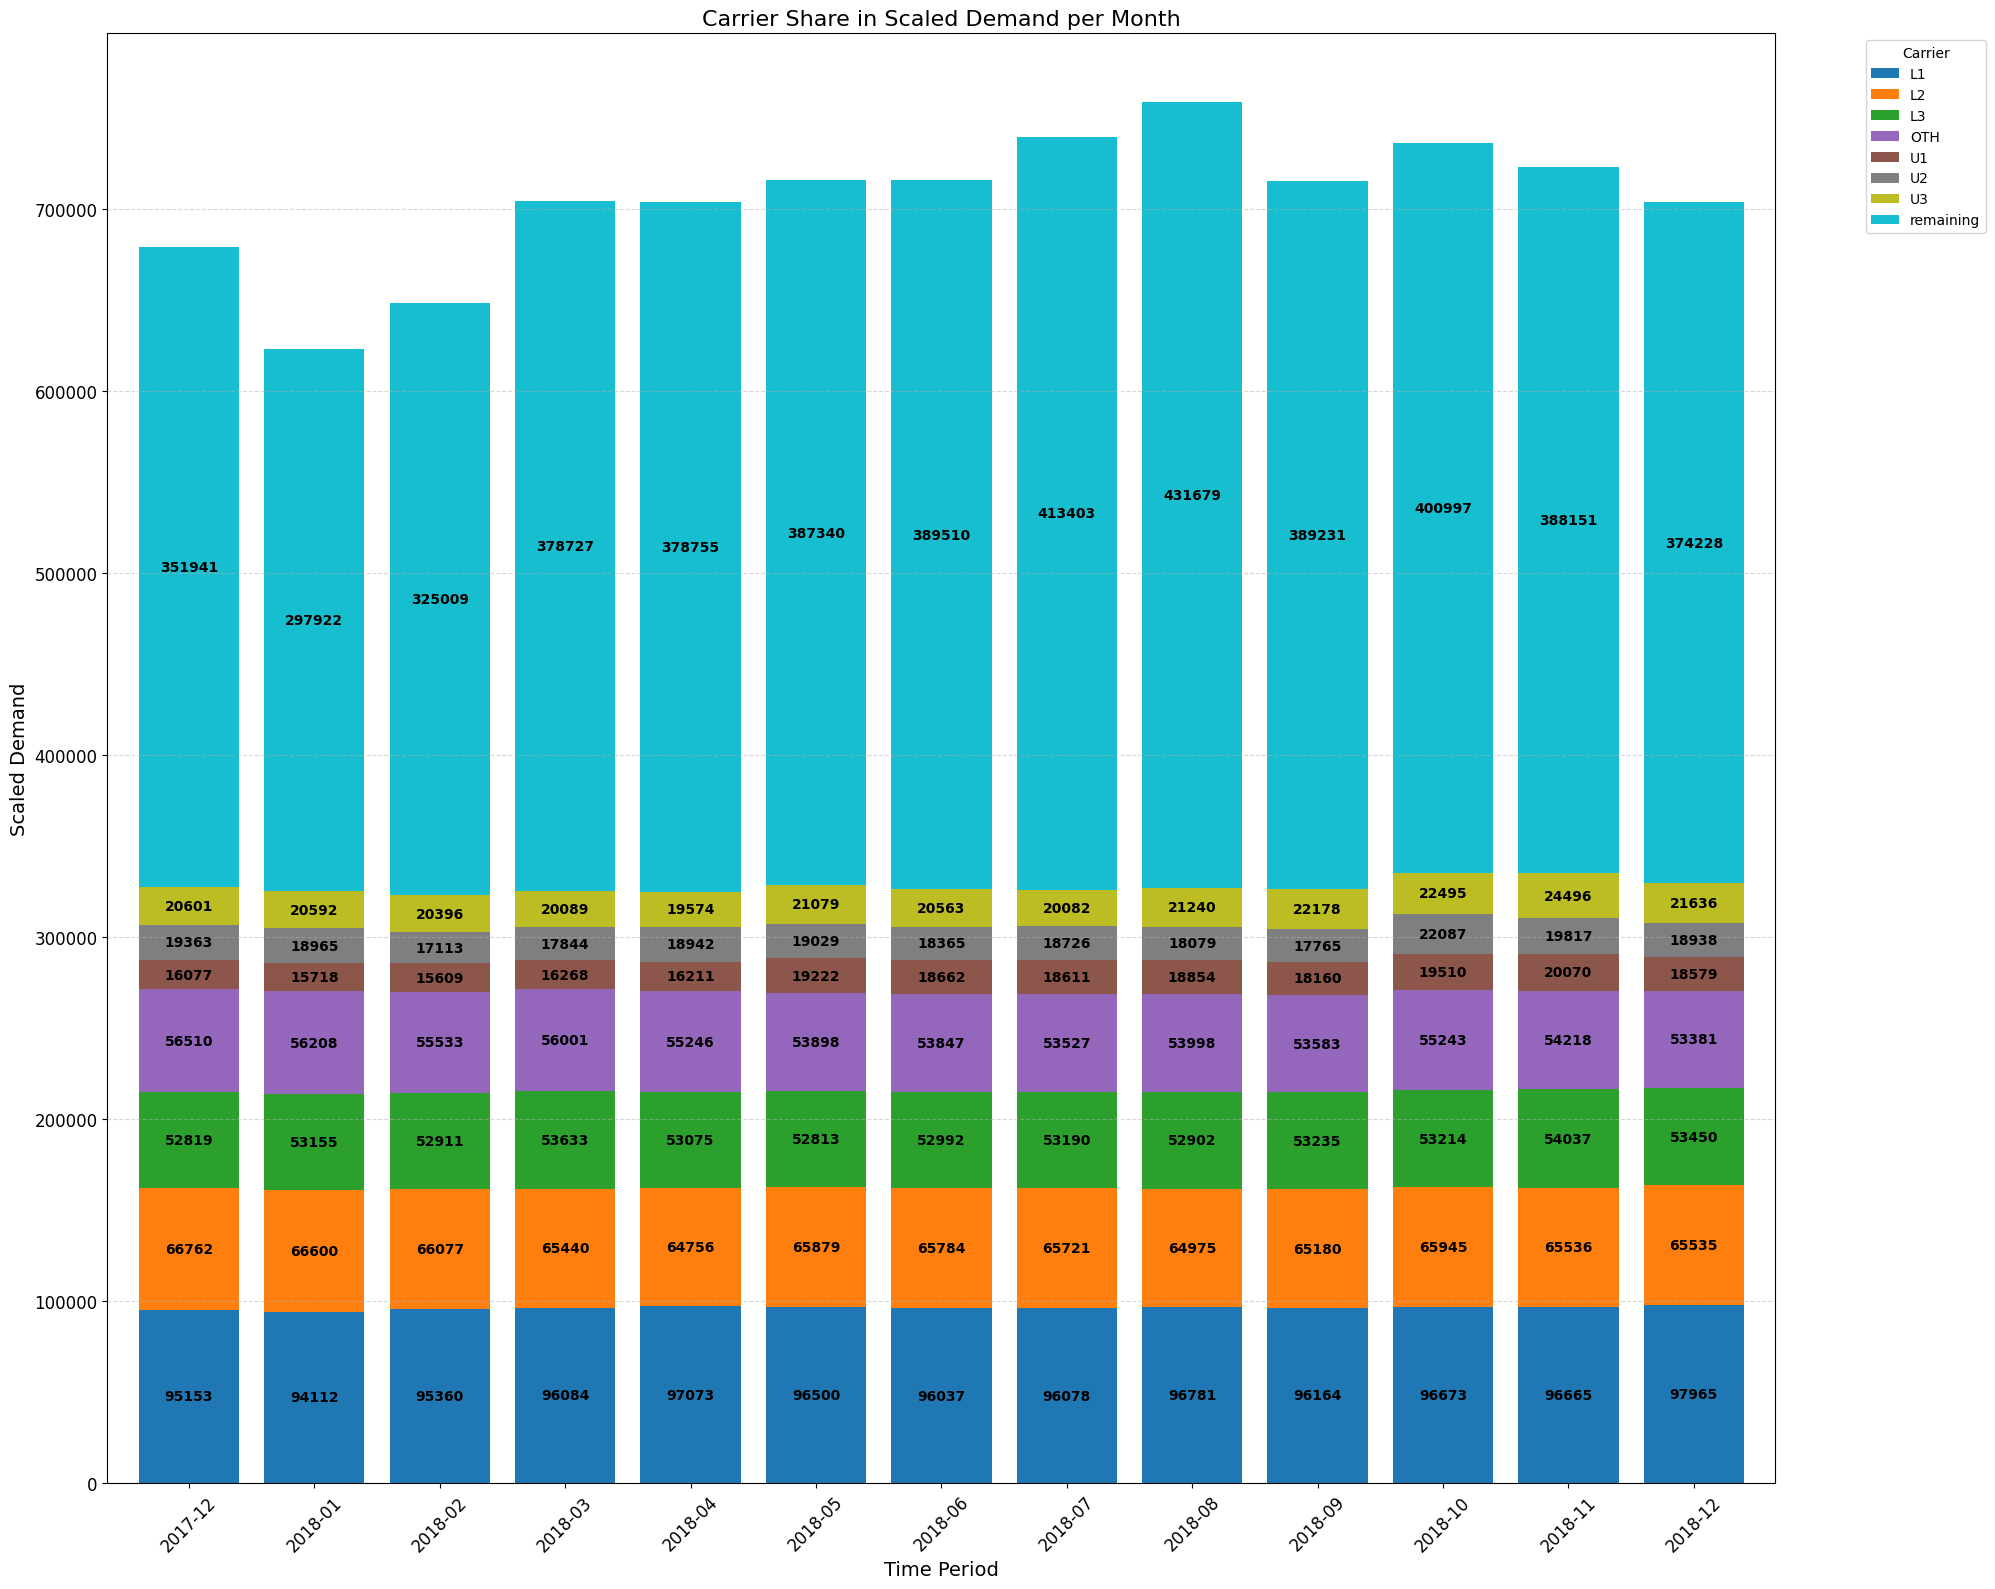

In [ ]:

# Ensure pivot_df contains only carrier columns (exclude origin & destination)
carrier_columns = [col for col in pivot_df.columns if col not in ['origin', 'destination', 'scaled_demand']]
pivot_df = pivot_df[carrier_columns]

# Plotting
fig, ax = plt.subplots(figsize=(20, 16))
pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)

# Adding labels inside each stack (Y-values for each carrier)
for i, (index, row) in enumerate(pivot_df.iterrows()):
    cumulative_height = 0
    for col in pivot_df.columns:
        value = row[col]
        if not pd.isna(value) and value > 0:  # Ensure valid numbers
            ax.text(i, cumulative_height + value / 2, f'{value:.0f}',
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')
        cumulative_height += value

# Move legend outside the plot
ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')

# Formatting
ax.set_ylabel("Scaled Demand", fontsize=14)
ax.set_xlabel("Time Period", fontsize=14)
ax.set_title("Carrier Share in Scaled Demand per Month", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


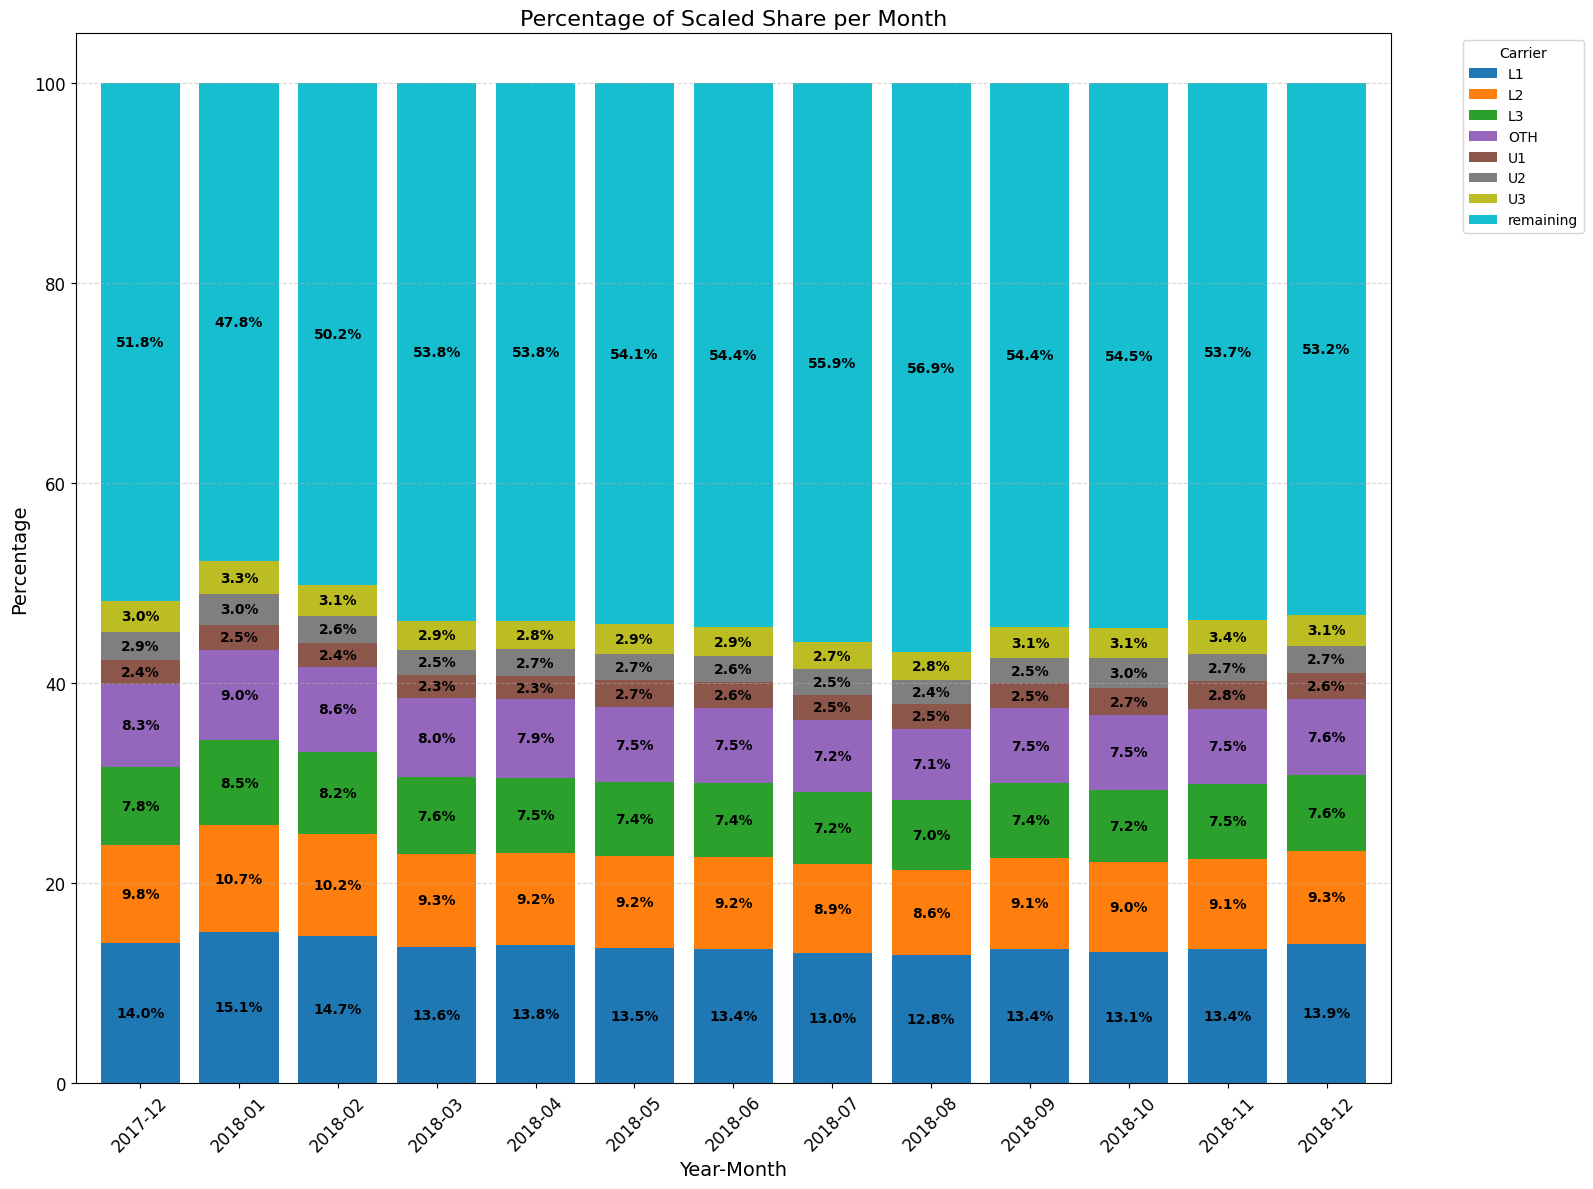

In [ ]:


# Ensure pivot_df contains only carrier columns
carrier_columns = [col for col in df_percentage.columns if col not in ['origin', 'destination']]
df_percentage = df_percentage[carrier_columns]

# Plotting
fig, ax = plt.subplots(figsize=(16, 12))
df_percentage.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)

# Adding percentage annotations inside each section
for n, (index, row) in enumerate(df_percentage.iterrows()):
    cumulative_height = 0
    for carrier in df_percentage.columns:
        value = row[carrier]
        if value > 2:  # Only display labels if > 2% for readability
            ax.text(n, cumulative_height + value / 2, f'{value:.1f}%',
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')
        cumulative_height += value

# Move legend outside the plot
ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')

# Formatting
ax.set_ylabel("Percentage", fontsize=14)
ax.set_xlabel("Year-Month", fontsize=14)
ax.set_title("Percentage of Scaled Share per Month", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Carrier Analysis

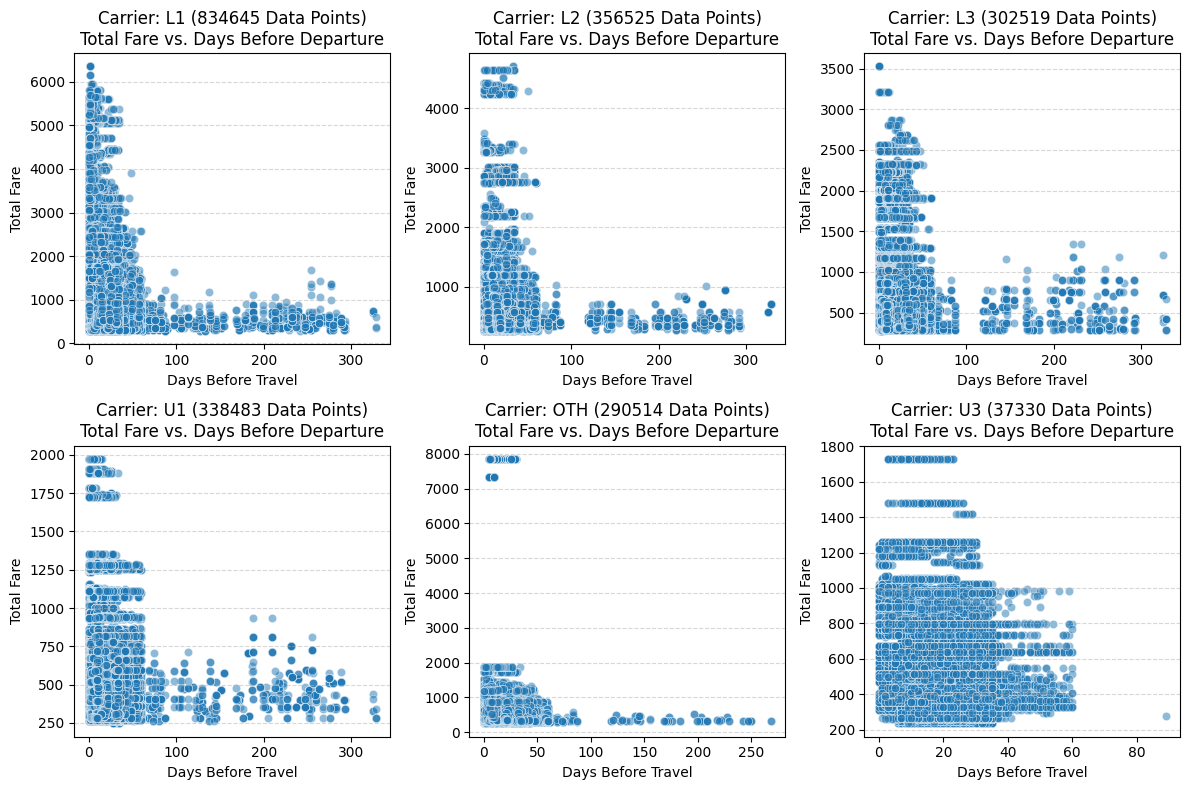

In [ ]:
# Ensure dates are in datetime format
train_fares_df['flt_departure_dt'] = pd.to_datetime(train_fares_df['flt_departure_dt'])
train_fares_df['observation_date'] = pd.to_datetime(train_fares_df['observation_date'])

# Compute days before departure
train_fares_df['days_before_departure'] = (train_fares_df['flt_departure_dt'] - train_fares_df['observation_date']).dt.days

# Get unique carriers
carriers = train_fares_df['carrier'].unique()

# Define grid layout
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()  # Flatten to iterate easily

# Plot scatter plots per carrier
for i, carrier in enumerate(carriers):
    carrier_data = train_fares_df[train_fares_df['carrier'] == carrier]
    num_data_points = len(carrier_data)  # Count data points for the carrier

    sns.scatterplot(x='days_before_departure', y='total_fare', data=carrier_data, alpha=0.5, ax=axes[i])

    axes[i].set_title(f"Carrier: {carrier} ({num_data_points} Data Points)\nTotal Fare vs. Days Before Departure")
    axes[i].set_xlabel("Days Before Travel")
    axes[i].set_ylabel("Total Fare")
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# Remove empty subplots if carriers are less than 6
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


/var/folders/cq/zrrjq02s1hq2p31y3d6tbfm80000gn/T/ipykernel_6867/2166215468.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='carrier', data=train_schedules_df, order=train_schedules_df['carrier'].value_counts().index,palette='coolwarm')


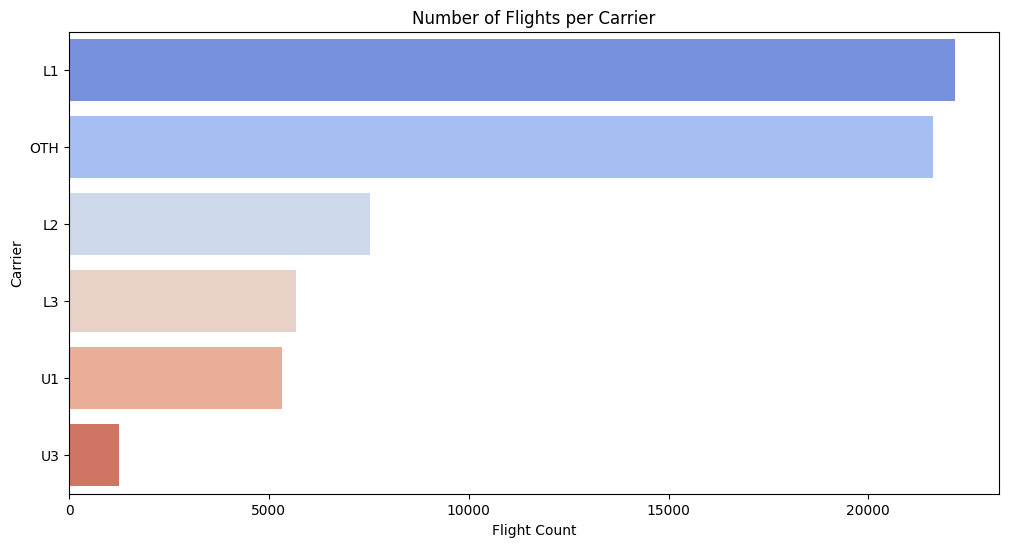

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(y='carrier', data=train_schedules_df, order=train_schedules_df['carrier'].value_counts().index,palette='coolwarm')
plt.title("Number of Flights per Carrier")
plt.xlabel("Flight Count")
plt.ylabel("Carrier")
plt.show()


/var/folders/cq/zrrjq02s1hq2p31y3d6tbfm80000gn/T/ipykernel_10834/3969141914.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='carrier', y='market_share', data=top_carriers, palette="coolwarm")


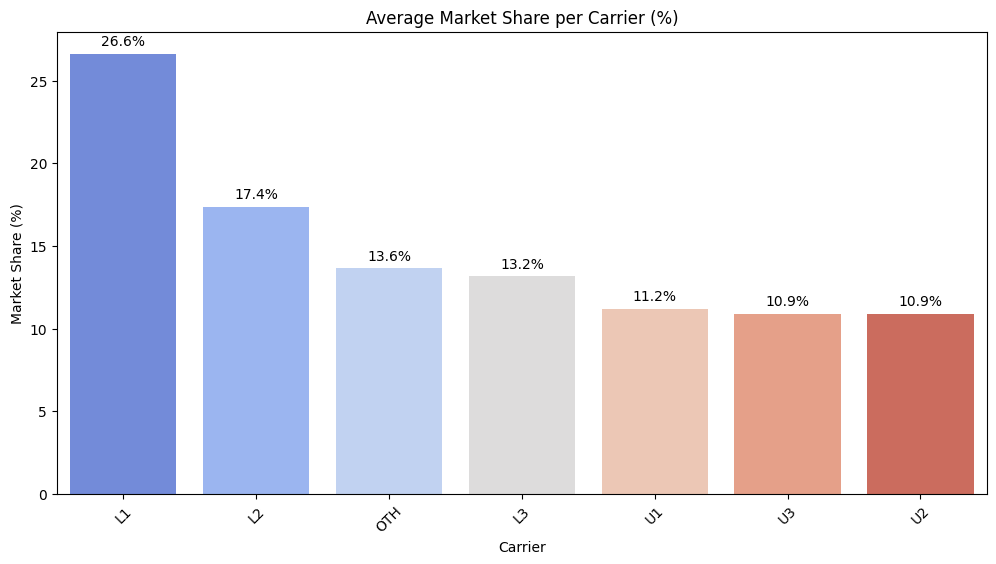

In [ ]:
# Convert market share to percentage
service_index_df['market_share'] = (service_index_df['scaled_share'] / service_index_df['scaled_demand']) * 100  # Multiply by 100 for percentage

# Get top carriers and sort
top_carriers = service_index_df.groupby('carrier')['market_share'].mean().reset_index()
top_carriers = top_carriers.sort_values('market_share', ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='carrier', y='market_share', data=top_carriers, palette="coolwarm")

# Formatting
plt.title("Average Market Share per Carrier (%)")
plt.xlabel("Carrier")
plt.ylabel("Market Share (%)")
plt.xticks(rotation=45)

# Show percentage labels on bars
for index, row in enumerate(top_carriers.itertuples()):
    plt.text(index, row.market_share + 0.5, f"{row.market_share:.1f}%", ha='center')

plt.show()


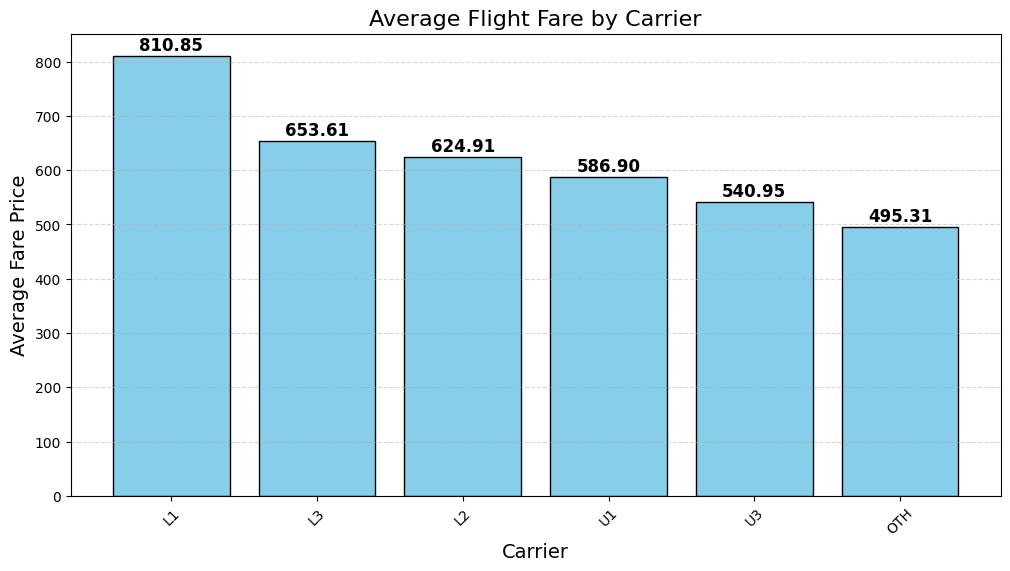

In [ ]:


# Compute the average fare price per carrier
avg_fare_by_carrier = merged_df.groupby('carrier')['total_fare'].mean().reset_index()

# Sort for better visualization
avg_fare_by_carrier = avg_fare_by_carrier.sort_values(by='total_fare', ascending=False)

# Plot the results
plt.figure(figsize=(12, 6))
bars = plt.bar(avg_fare_by_carrier['carrier'], avg_fare_by_carrier['total_fare'], color='skyblue', edgecolor='black')

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, f'{yval:.2f}', ha='center', fontsize=12, fontweight='bold')

# Labels and title
plt.xlabel("Carrier", fontsize=14)
plt.ylabel("Average Fare Price", fontsize=14)
plt.title("Average Flight Fare by Carrier", fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show the plot
plt.show()


### Route Analysis

/var/folders/cq/zrrjq02s1hq2p31y3d6tbfm80000gn/T/ipykernel_1531/1437863027.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_fare', y='route', data=top_expensive_routes, palette="coolwarm")


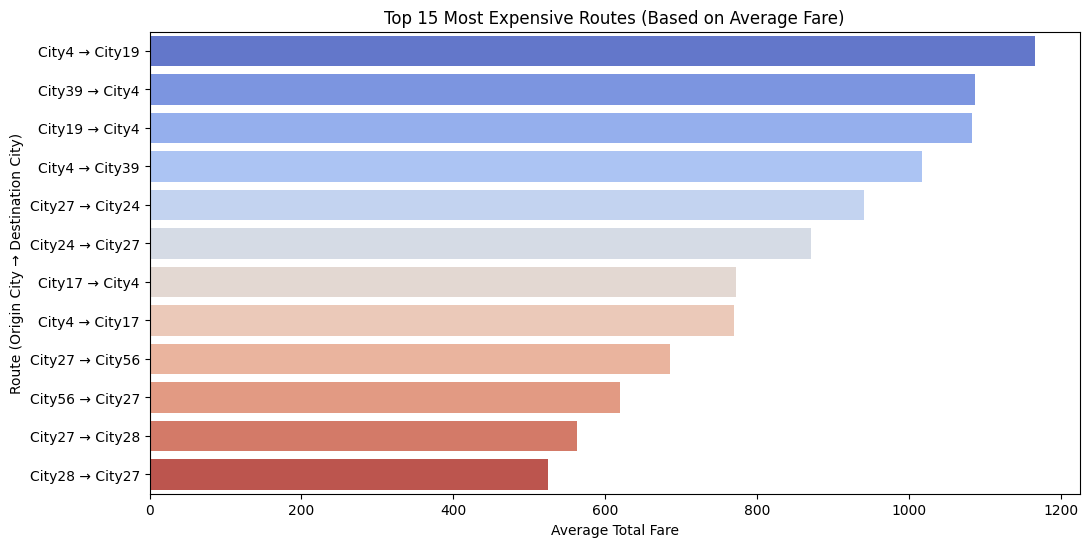

In [ ]:


# Compute average fare per route
route_fare = train_fares_df.groupby(['origin', 'destination'])['total_fare'].mean().reset_index()

# Merge with city names for better readability
route_fare = route_fare.merge(
    train_fares_df[['origin', 'origin_city']].drop_duplicates(),
    on='origin',
    how='left'
)

route_fare = route_fare.merge(
    train_fares_df[['destination', 'destination_city']].drop_duplicates(),
    on='destination',
    how='left'
)

# Create a new column for city-to-city routes
route_fare['route'] = route_fare['origin_city'] + " → " + route_fare['destination_city']

# Sort by average fare and select the top 15 expensive routes
top_expensive_routes = route_fare.sort_values('total_fare', ascending=False).head(15)

# Plot the expensive routes
plt.figure(figsize=(12, 6))
sns.barplot(x='total_fare', y='route', data=top_expensive_routes, palette="coolwarm")

plt.title("Top 15 Most Expensive Routes (Based on Average Fare)")
plt.xlabel("Average Total Fare")
plt.ylabel("Route (Origin City → Destination City)")
plt.show()


/var/folders/cq/zrrjq02s1hq2p31y3d6tbfm80000gn/T/ipykernel_1531/4023561506.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_fare', y='route', data=top_expensive_routes, palette="coolwarm")


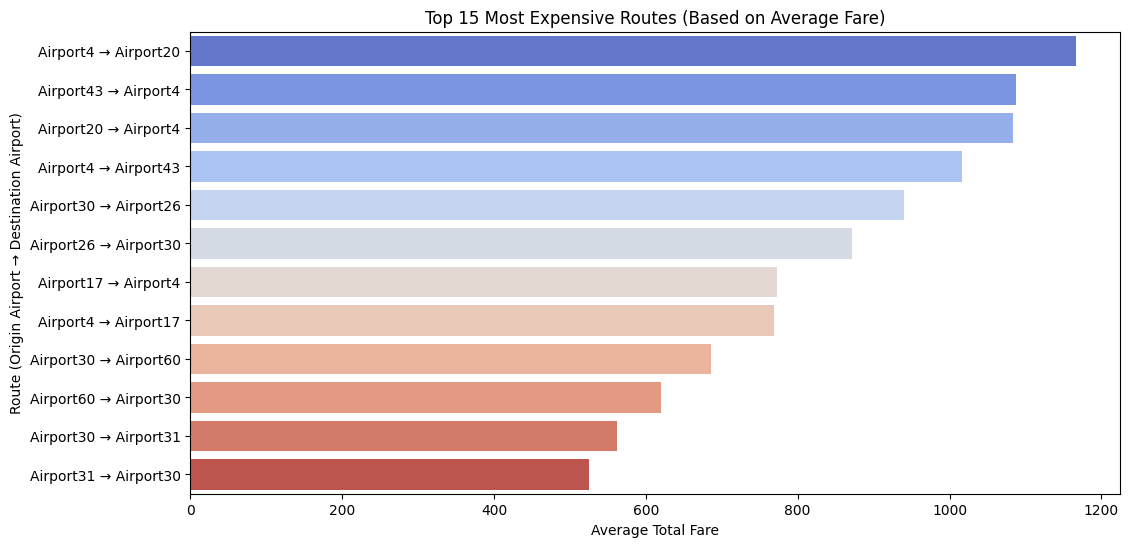

In [ ]:


# Compute average fare per airport route
route_fare = train_fares_df.groupby(['origin', 'destination'])['total_fare'].mean().reset_index()

# Create a new column for Airport-to-Airport routes
route_fare['route'] = route_fare['origin'] + " → " + route_fare['destination']

# Sort by average fare and select the top 15 expensive routes
top_expensive_routes = route_fare.sort_values('total_fare', ascending=False).head(15)

# Plot the expensive routes
plt.figure(figsize=(12, 6))
sns.barplot(x='total_fare', y='route', data=top_expensive_routes, palette="coolwarm")

plt.title("Top 15 Most Expensive Routes (Based on Average Fare)")
plt.xlabel("Average Total Fare")
plt.ylabel("Route (Origin Airport → Destination Airport)")
plt.show()


<Figure size 1200x600 with 0 Axes>

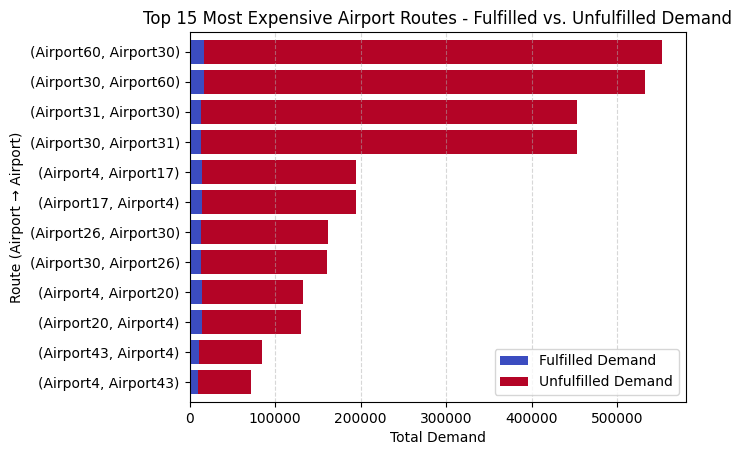

<Figure size 1200x600 with 0 Axes>

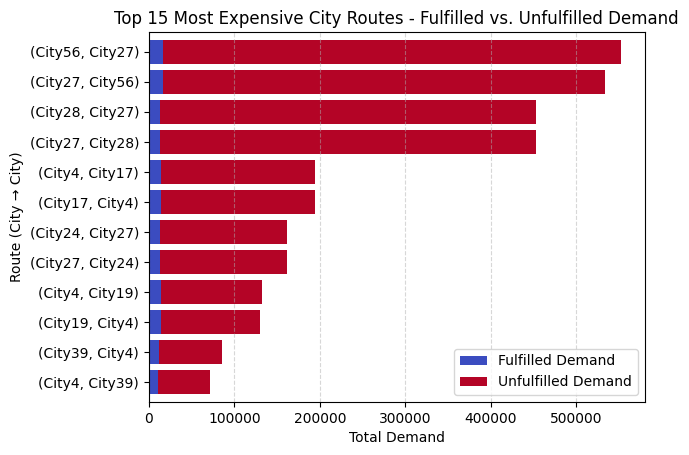

In [ ]:


# Drop existing city columns in service_index_df if they exist (to avoid duplicates)
service_index_df = service_index_df.drop(columns=['origin_city', 'destination_city'], errors='ignore')

# Merge service_index_df with train_fares_df to get city names for airports
service_index_df = service_index_df.merge(
    train_fares_df[['origin', 'destination', 'origin_city', 'destination_city']].drop_duplicates(),
    on=['origin', 'destination'],
    how='left'
)

### STEP 1: Aggregate Fare Data for Airports ###
airport_fare = train_fares_df.groupby(['origin', 'destination'])['total_fare'].mean().reset_index()
airport_fulfilled = service_index_df.groupby(['origin', 'destination'])[['scaled_share', 'scaled_demand']].sum().reset_index()

# Merge to compute demand fulfillment for Airports
airport_fare = airport_fare.merge(airport_fulfilled, on=['origin', 'destination'], how='left')
airport_fare['unfulfilled_demand'] = airport_fare['scaled_demand'] - airport_fare['scaled_share']
airport_fare['fulfilled_percentage'] = (airport_fare['scaled_share'] / airport_fare['scaled_demand']) * 100

# Get Top 15 Most Expensive Airport Routes (sorted by demand)
top_airport_routes = airport_fare.sort_values('scaled_demand', ascending=False).head(15)

### STEP 2: Aggregate Fare Data for Cities ###
city_fare = train_fares_df.groupby(['origin_city', 'destination_city'])['total_fare'].mean().reset_index()
city_fulfilled = service_index_df.groupby(['origin_city', 'destination_city'])[['scaled_share', 'scaled_demand']].sum().reset_index()

# Merge to compute demand fulfillment for Cities
city_fare = city_fare.merge(city_fulfilled, on=['origin_city', 'destination_city'], how='left')
city_fare['unfulfilled_demand'] = city_fare['scaled_demand'] - city_fare['scaled_share']
city_fare['fulfilled_percentage'] = (city_fare['scaled_share'] / city_fare['scaled_demand']) * 100

# Get Top 15 Most Expensive City Routes (sorted by demand)
top_city_routes = city_fare.sort_values('scaled_demand', ascending=False).head(15)

### STEP 3: Plot Most Expensive Airport Routes - Demand Fulfillment ###
plt.figure(figsize=(12,6))
top_airport_routes = top_airport_routes.set_index(['origin', 'destination']).sort_values('scaled_demand', ascending=True)
top_airport_routes[['scaled_share', 'unfulfilled_demand']].plot(
    kind='barh', stacked=True, colormap='coolwarm', width=0.8
)
plt.xlabel("Total Demand")
plt.ylabel("Route (Airport → Airport)")
plt.title("Top 15 Most Expensive Airport Routes - Fulfilled vs. Unfulfilled Demand")
plt.legend(["Fulfilled Demand", "Unfulfilled Demand"])
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

### STEP 4: Plot Most Expensive City Routes - Demand Fulfillment ###
plt.figure(figsize=(12,6))
top_city_routes = top_city_routes.set_index(['origin_city', 'destination_city']).sort_values('scaled_demand', ascending=True)
top_city_routes[['scaled_share', 'unfulfilled_demand']].plot(
    kind='barh', stacked=True, colormap='coolwarm', width=0.8
)
plt.xlabel("Total Demand")
plt.ylabel("Route (City → City)")
plt.title("Top 15 Most Expensive City Routes - Fulfilled vs. Unfulfilled Demand")
plt.legend(["Fulfilled Demand", "Unfulfilled Demand"])
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


/var/folders/cq/zrrjq02s1hq2p31y3d6tbfm80000gn/T/ipykernel_1531/3013449118.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_increased_routes['route'],


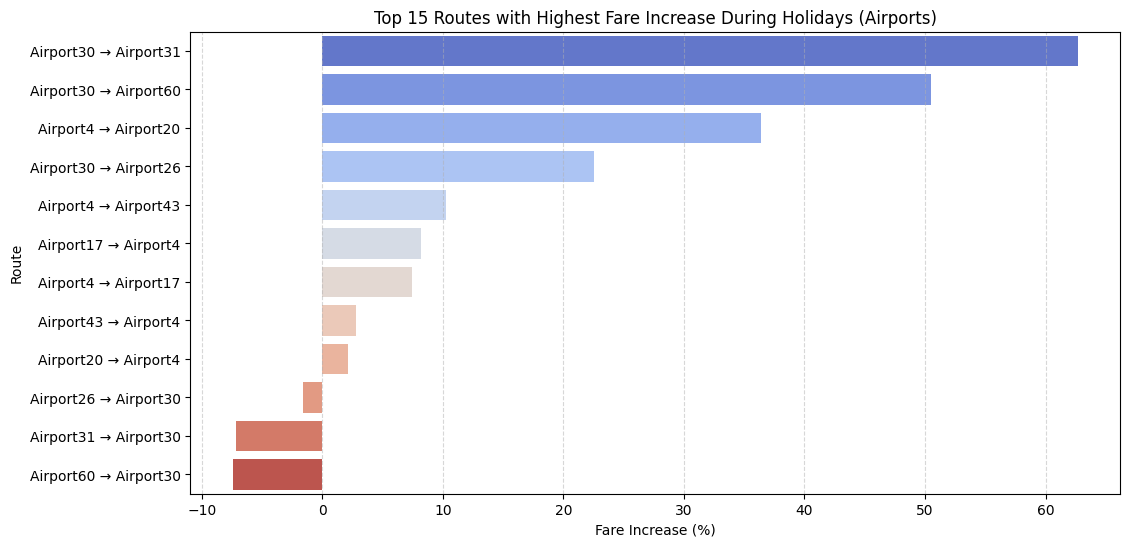

/var/folders/cq/zrrjq02s1hq2p31y3d6tbfm80000gn/T/ipykernel_1531/3013449118.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_increased_cities['route'],


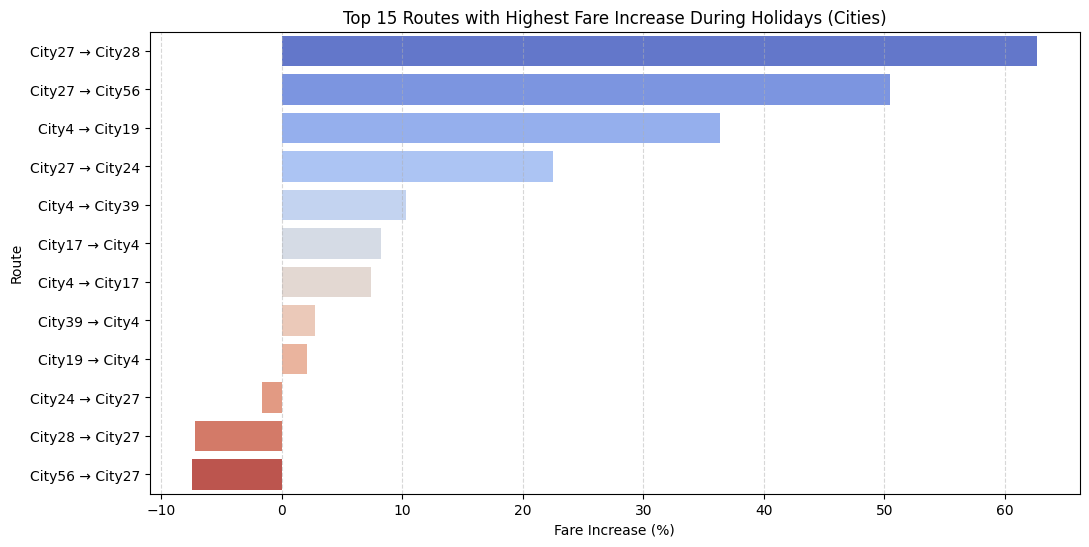

In [ ]:


# Compute the average fare per route during holidays and non-holidays for AIRPORTS
route_fare_comparison = train_fares_df.groupby(['origin', 'destination', 'is_holiday'])['total_fare'].mean().reset_index()

# Pivot the table to compare holiday vs. non-holiday fares per route
route_fare_pivot = route_fare_comparison.pivot(index=['origin', 'destination'], columns='is_holiday', values='total_fare').reset_index()
route_fare_pivot.columns = ['origin', 'destination', 'non_holiday_fare', 'holiday_fare']

# **Remove routes where origin == destination**
route_fare_pivot = route_fare_pivot[route_fare_pivot['origin'] != route_fare_pivot['destination']]

# Calculate percentage fare increase during holidays
route_fare_pivot['fare_increase_percentage'] = ((route_fare_pivot['holiday_fare'] - route_fare_pivot['non_holiday_fare']) /
                                                 route_fare_pivot['non_holiday_fare']) * 100

# Sort routes by highest fare increase
top_increased_routes = route_fare_pivot.sort_values(by='fare_increase_percentage', ascending=False).head(15)

# Ensure origin and destination are treated as strings before concatenation
top_increased_routes['route'] = top_increased_routes['origin'].astype(str) + " → " + top_increased_routes['destination'].astype(str)

# Plot the top 15 routes with the highest fare increase (AIRPORT LEVEL)
plt.figure(figsize=(12,6))
sns.barplot(y=top_increased_routes['route'],
            x=top_increased_routes['fare_increase_percentage'], palette="coolwarm")

plt.title("Top 15 Routes with Highest Fare Increase During Holidays (Airports)")
plt.xlabel("Fare Increase (%)")
plt.ylabel("Route")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


### **Same Analysis for CITIES** ###
# Compute the average fare per route during holidays and non-holidays for CITIES
city_fare_comparison = train_fares_df.groupby(['origin_city', 'destination_city', 'is_holiday'])['total_fare'].mean().reset_index()

# Pivot the table to compare holiday vs. non-holiday fares per route
city_fare_pivot = city_fare_comparison.pivot(index=['origin_city', 'destination_city'], columns='is_holiday', values='total_fare').reset_index()
city_fare_pivot.columns = ['origin_city', 'destination_city', 'non_holiday_fare', 'holiday_fare']

# **Remove routes where origin == destination (same city)**
city_fare_pivot = city_fare_pivot[city_fare_pivot['origin_city'] != city_fare_pivot['destination_city']]

# Calculate percentage fare increase during holidays
city_fare_pivot['fare_increase_percentage'] = ((city_fare_pivot['holiday_fare'] - city_fare_pivot['non_holiday_fare']) /
                                                 city_fare_pivot['non_holiday_fare']) * 100

# Sort routes by highest fare increase
top_increased_cities = city_fare_pivot.sort_values(by='fare_increase_percentage', ascending=False).head(15)

# Ensure origin and destination are treated as strings before concatenation
top_increased_cities['route'] = top_increased_cities['origin_city'].astype(str) + " → " + top_increased_cities['destination_city'].astype(str)

# Plot the top 15 routes with the highest fare increase (CITY LEVEL)
plt.figure(figsize=(12,6))
sns.barplot(y=top_increased_cities['route'],
            x=top_increased_cities['fare_increase_percentage'], palette="coolwarm")

plt.title("Top 15 Routes with Highest Fare Increase During Holidays (Cities)")
plt.xlabel("Fare Increase (%)")
plt.ylabel("Route")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


### Duration of the Day

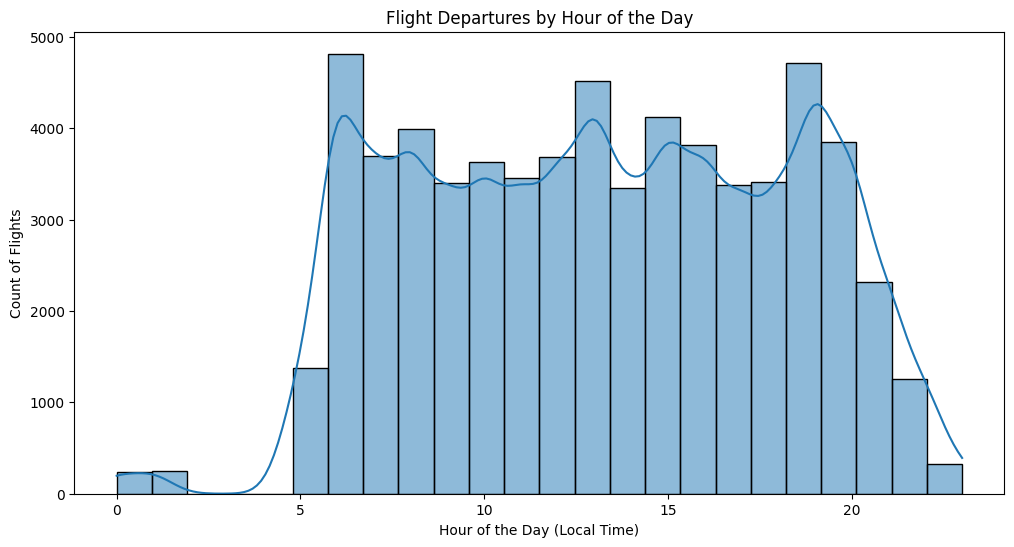

In [ ]:
train_schedules_df['departure_hour'] = train_schedules_df['flt_departure_local_time'].dt.hour

plt.figure(figsize=(12,6))
sns.histplot(train_schedules_df['departure_hour'], bins=24, kde=True)
plt.title("Flight Departures by Hour of the Day")
plt.xlabel("Hour of the Day (Local Time)")
plt.ylabel("Count of Flights")
plt.show()


## Feature Creation

### Data Merging

In [ ]:
# Ensure datetime formats are consistent before merging
train_fares_df['flt_departure_dt'] = pd.to_datetime(train_fares_df['flt_departure_dt'])
train_schedules_df['flt_departure_dt'] = pd.to_datetime(train_schedules_df['flt_departure_dt'])

# Perform a Many-to-One Merge on all columns
merged_df = train_fares_df.merge(
    train_schedules_df,
    on=['carrier', 'flt_num', 'origin', 'destination', 'flt_departure_dt'],
    how='left'  # Left join to keep all rows from `train_fares_df`
)

merged_df.head()


,origin,destination,carrier,flt_num,flt_departure_dt,observation_date,total_fare,origin_city,destination_city,flt_departure_local_time,flt_arrival_local_time,flt_departure_gmt,flt_arrival_gmt
0,Airport4,Airport43,L1,5911,2018-01-03,2017-11-29,538,City4,City39,2018-01-03 17:00:00.0,2018-01-03 19:37:00.0,2018-01-03 23:00:00.0,2018-01-04 01:37:00.0
1,Airport4,Airport43,L1,6589,2018-01-03,2017-11-29,538,City4,City39,2018-01-03 08:55:00.0,2018-01-03 11:34:00.0,2018-01-03 14:55:00.0,2018-01-03 17:34:00.0
2,Airport4,Airport43,L1,2689,2018-01-03,2017-11-29,538,City4,City39,2018-01-03 06:45:00.0,2018-01-03 09:25:00.0,2018-01-03 12:45:00.0,2018-01-03 15:25:00.0
3,Airport4,Airport43,L2,8244,2018-01-03,2017-11-29,557,City4,City39,2018-01-03 08:10:00.0,2018-01-03 10:50:00.0,2018-01-03 14:10:00.0,2018-01-03 16:50:00.0
4,Airport4,Airport43,L2,8523,2018-01-03,2017-11-29,557,City4,City39,2018-01-03 18:27:00.0,2018-01-03 21:08:00.0,2018-01-04 00:27:00.0,2018-01-04 03:08:00.0


Did Left join on Train Fares and Train Shcedules. Idea was that I want to keep as many rows as possible.

### Feature Creation

In [ ]:
# Ensure datetime formats are consistent before merging
train_fares_df['flt_departure_dt'] = pd.to_datetime(train_fares_df['flt_departure_dt'])
train_schedules_df['flt_departure_dt'] = pd.to_datetime(train_schedules_df['flt_departure_dt'])

# Perform a Many-to-One Merge on all columns
merged_df = train_fares_df.merge(
    train_schedules_df,
    on=['carrier', 'flt_num', 'origin', 'destination', 'flt_departure_dt'],
    how='left'  # Left join to keep all rows from `train_fares_df`
)

merged_df.head()


,origin,destination,carrier,flt_num,flt_departure_dt,observation_date,total_fare,origin_city,destination_city,flt_departure_local_time,flt_arrival_local_time,flt_departure_gmt,flt_arrival_gmt
0,Airport4,Airport43,L1,5911,2018-01-03,2017-11-29,538,City4,City39,2018-01-03 17:00:00.0,2018-01-03 19:37:00.0,2018-01-03 23:00:00.0,2018-01-04 01:37:00.0
1,Airport4,Airport43,L1,6589,2018-01-03,2017-11-29,538,City4,City39,2018-01-03 08:55:00.0,2018-01-03 11:34:00.0,2018-01-03 14:55:00.0,2018-01-03 17:34:00.0
2,Airport4,Airport43,L1,2689,2018-01-03,2017-11-29,538,City4,City39,2018-01-03 06:45:00.0,2018-01-03 09:25:00.0,2018-01-03 12:45:00.0,2018-01-03 15:25:00.0
3,Airport4,Airport43,L2,8244,2018-01-03,2017-11-29,557,City4,City39,2018-01-03 08:10:00.0,2018-01-03 10:50:00.0,2018-01-03 14:10:00.0,2018-01-03 16:50:00.0
4,Airport4,Airport43,L2,8523,2018-01-03,2017-11-29,557,City4,City39,2018-01-03 18:27:00.0,2018-01-03 21:08:00.0,2018-01-04 00:27:00.0,2018-01-04 03:08:00.0


In [ ]:
merged_df['flt_departure_local_time'] = pd.to_datetime(merged_df['flt_departure_local_time'])

In [ ]:
merged_df['flt_dept_day'] = merged_df.flt_departure_dt.dt.day
merged_df['flt_dept_month'] = merged_df.flt_departure_dt.dt.month
merged_df['flt_dept_year'] = merged_df.flt_departure_dt.dt.year
merged_df['flt_dept_hour'] = merged_df.flt_departure_local_time.dt.hour
merged_df['flt_dept_minute'] = merged_df.flt_departure_local_time.dt.minute
merged_df['flt_dept_second'] = merged_df.flt_departure_local_time.dt.second

In [ ]:
merged_df['flt_departure_dt'] = pd.to_datetime(merged_df['flt_departure_dt'])

# Extract Weekday Name
merged_df['departure_weekday'] = merged_df['flt_departure_dt'].dt.day_name()

# Create a Weekend Column (1 = Weekend, 0 = Weekday)
merged_df['is_weekend'] = merged_df['flt_departure_dt'].dt.weekday.isin([4, 5, 6]).astype(int)

# Display updated dataframe
merged_df.head()


,origin,destination,carrier,flt_num,flt_departure_dt,observation_date,total_fare,origin_city,destination_city,flt_departure_local_time,...,flt_departure_gmt,flt_arrival_gmt,flt_dept_day,flt_dept_month,flt_dept_year,flt_dept_hour,flt_dept_minute,flt_dept_second,departure_weekday,is_weekend
0,Airport4,Airport43,L1,5911,2018-01-03,2017-11-29,538,City4,City39,2018-01-03 17:00:00,...,2018-01-03 23:00:00.0,2018-01-04 01:37:00.0,3,1,2018,17.0,0.0,0.0,Wednesday,0
1,Airport4,Airport43,L1,6589,2018-01-03,2017-11-29,538,City4,City39,2018-01-03 08:55:00,...,2018-01-03 14:55:00.0,2018-01-03 17:34:00.0,3,1,2018,8.0,55.0,0.0,Wednesday,0
2,Airport4,Airport43,L1,2689,2018-01-03,2017-11-29,538,City4,City39,2018-01-03 06:45:00,...,2018-01-03 12:45:00.0,2018-01-03 15:25:00.0,3,1,2018,6.0,45.0,0.0,Wednesday,0
3,Airport4,Airport43,L2,8244,2018-01-03,2017-11-29,557,City4,City39,2018-01-03 08:10:00,...,2018-01-03 14:10:00.0,2018-01-03 16:50:00.0,3,1,2018,8.0,10.0,0.0,Wednesday,0
4,Airport4,Airport43,L2,8523,2018-01-03,2017-11-29,557,City4,City39,2018-01-03 18:27:00,...,2018-01-04 00:27:00.0,2018-01-04 03:08:00.0,3,1,2018,18.0,27.0,0.0,Wednesday,0


In [ ]:
merged_df['flt_arrival_gmt'] = pd.to_datetime(merged_df['flt_arrival_gmt'])
merged_df['flt_departure_gmt'] = pd.to_datetime(merged_df['flt_departure_gmt'])
merged_df['observation_date'] = pd.to_datetime(merged_df['observation_date'])
merged_df['flt_duration'] = (merged_df['flt_arrival_gmt'] - merged_df['flt_departure_gmt']).dt.seconds/3600

In [ ]:
# Define US Federal Holidays for 2018
cal = USFederalHolidayCalendar()
holidays = pd.to_datetime(cal.holidays(start='2017-11-01', end='2018-12-31'))

# Function to check if a date is within ±3 days of a holiday
def is_near_holiday(x):
    """
    Returns 1 if the given date is within 3 days before/after a US holiday, else 0.
    """
    for h_day in holidays:
        try:
            if abs((h_day - x).days) <= 7:  # Check if within 3 days of a holiday
                return 1  # Near holiday
        except TypeError:
            continue
    return 0  # Not near a holiday

# Apply function to create a boolean variable
merged_df['near_holiday'] = merged_df['flt_departure_dt'].apply(is_near_holiday)


Based on time zone analysis we found that the data is from USA.

In [ ]:
# Extract the week number (ISO Week Number: 1-52)
merged_df['week_number'] = merged_df['flt_departure_dt'].dt.isocalendar().week

In [ ]:
merged_df['days_before_departure'] = (merged_df['flt_departure_dt'] - merged_df['observation_date']).dt.days

### Dropping Unwanted columns

In [ ]:
features_not_required = ['flt_arrival_local_time',
       'flt_departure_gmt', 'flt_arrival_gmt', 'observation_date', 'flt_departure_dt',
                        'flt_departure_local_time']

X = merged_df[[col for col in merged_df.columns if col not in features_not_required]]
y = merged_df[['total_fare']]
X = X[[col for col in X.columns if col!='total_fare']]

## Data Splitting

In [ ]:



# Bin the target variable (fare price) into 10 quantiles for stratified sampling
y = y.values.ravel()  # OR y = y.squeeze()

# Now apply stratified binning
y_binned = pd.qcut(y, q=10, labels=False, duplicates='drop')

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_binned, random_state=42
)


Tried to keep the set as stratified as possible

### Label ENcoding

In [ ]:

# Define categorical columns
cat_columns = ['origin', 'destination', 'origin_city', 'destination_city', 'carrier','departure_weekday']

# Apply Label Encoding
label_encoders = {}
for col in cat_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])  # Use same encoder on test set
    label_encoders[col] = le  # Store encoders for later use


Label Encoding the Categorical columns, Label encode does not create many columns like one hot encode , hence this is computationally efficient.

## Model Training

### Without Hyper Parameter Tuning

#### Random Forrest

In [ ]:


# Initialize Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_depth=10,      # Maximum depth of trees
    random_state=42,
    n_jobs=-1          # Use all available CPU cores
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Evaluate Performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 173.15
Root Mean Squared Error (RMSE): 305.09
R² Score: 0.6477


In [ ]:
mape_value = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_value:.2f}%")

MAPE: 27.01%


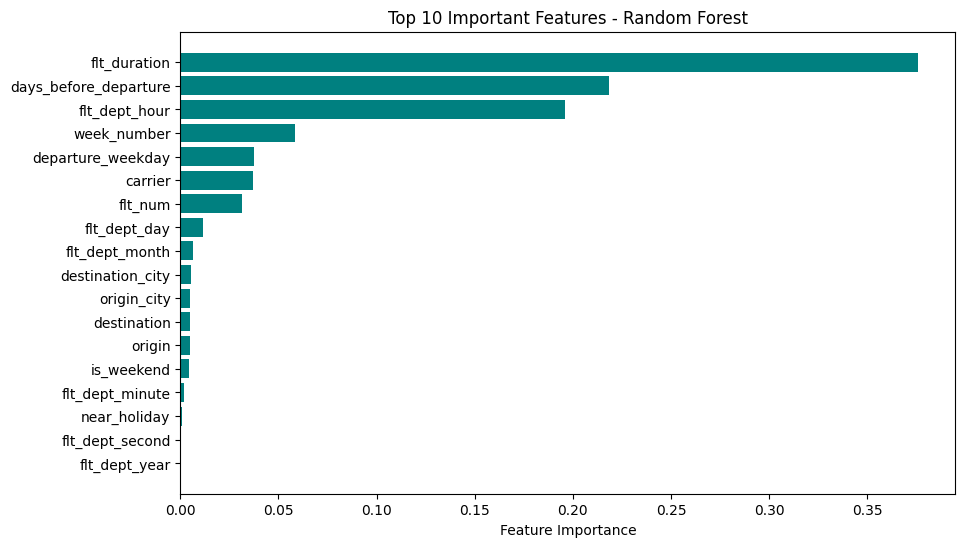

In [ ]:
# Get feature importance from the trained Random Forest model
feature_importance = rf_model.feature_importances_
feature_names = X_train.columns

# Sort feature importance values in descending order
sorted_idx = np.argsort(feature_importance)[::-1]

# Select top 10 important features
top_n = 30
top_features = np.array(feature_names)[sorted_idx[:top_n]]
top_importance = feature_importance[sorted_idx[:top_n]]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], top_importance[::-1], color='teal')
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features - Random Forest")
plt.show()


In [ ]:

# Save the trained model
joblib.dump(rf_model, 'random_forest_fare_prediction_take_1_no_hyperTuning.pkl')
print("Model saved successfully!")


Model saved successfully!


#### XgBoost

In [ ]:


# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=200,        # Number of trees
    learning_rate=0.05,      # Step size shrinkage
    max_depth=6,             # Maximum depth of trees
    subsample=0.8,           # Subsampling ratio for training instances
    colsample_bytree=0.8,    # Feature subsampling per tree
    random_state=42,
    n_jobs=-1
)

# Train XGBoost
xgb_model.fit(X_train, y_train)

# Predict using XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost Performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Performance:")
print(f"  - MAE: {mae_xgb:.2f}")
print(f"  - RMSE: {rmse_xgb:.2f}")
print(f"  - R² Score: {r2_xgb:.4f}")



XGBoost Performance:
  - MAE: 151.10
  - RMSE: 277.25
  - R² Score: 0.7091


In [ ]:
mape_value = mean_absolute_percentage_error(y_test, y_pred_xgb)
print(f"MAPE: {mape_value:.2f}%")

MAPE: 22.56%


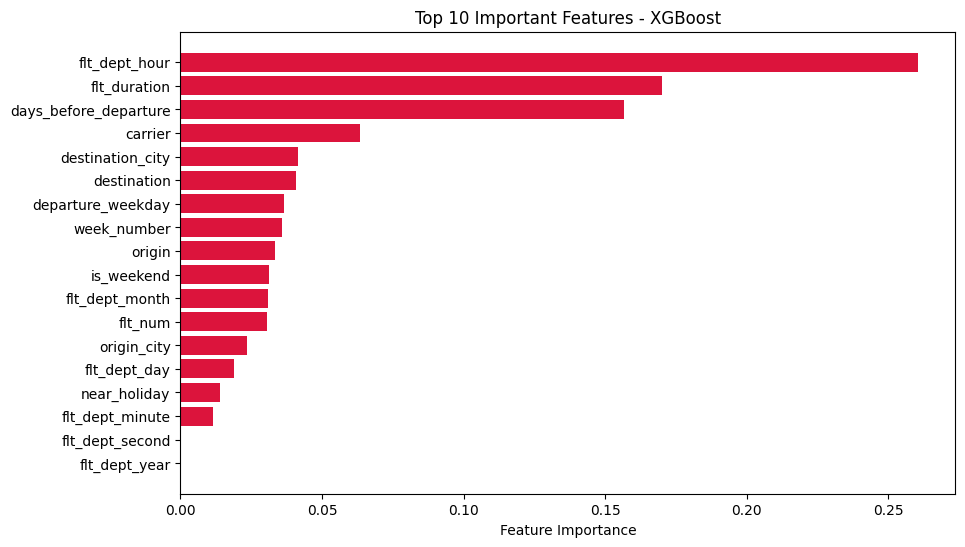

In [ ]:
# Get feature importance values from XGBoost
xgb_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(xgb_importance)[::-1]

# Select top 10 important features
top_n = 30
top_features = np.array(feature_names)[sorted_idx[:top_n]]
top_importance = xgb_importance[sorted_idx[:top_n]]

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], top_importance[::-1], color='crimson')
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features - XGBoost")
plt.show()


#### CatBoost

In [ ]:
# Initialize CatBoost Regressor
cat_model = CatBoostRegressor(
    iterations=200,         # Number of boosting rounds
    learning_rate=0.05,     # Step size
    depth=6,                # Depth of trees
    loss_function='RMSE',   # Use RMSE as loss function
    random_seed=42,
    verbose=100             # Show training progress
)

# Train CatBoost
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=[], early_stopping_rounds=20)

# Predict using CatBoost
y_pred_cat = cat_model.predict(X_test)

# Evaluate CatBoost Performance
mae_cat = mean_absolute_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
r2_cat = r2_score(y_test, y_pred_cat)

print(f"\nCatBoost Performance:")
print(f"  - MAE: {mae_cat:.2f}")
print(f"  - RMSE: {rmse_cat:.2f}")
print(f"  - R² Score: {r2_cat:.4f}")

0:	learn: 504.8634616	test: 502.8314154	best: 502.8314154 (0)	total: 152ms	remaining: 30.3s
100:	learn: 318.4341808	test: 318.9954771	best: 318.9954771 (100)	total: 5.83s	remaining: 5.71s
199:	learn: 301.1660670	test: 301.9129746	best: 301.9129746 (199)	total: 11.1s	remaining: 0us

bestTest = 301.9129746
bestIteration = 199


CatBoost Performance:
  - MAE: 169.97
  - RMSE: 301.91
  - R² Score: 0.6550


In [ ]:
mape_value = mean_absolute_percentage_error(y_test, y_pred_cat)
print(f"MAPE: {mape_value:.2f}%")

MAPE: 25.54%


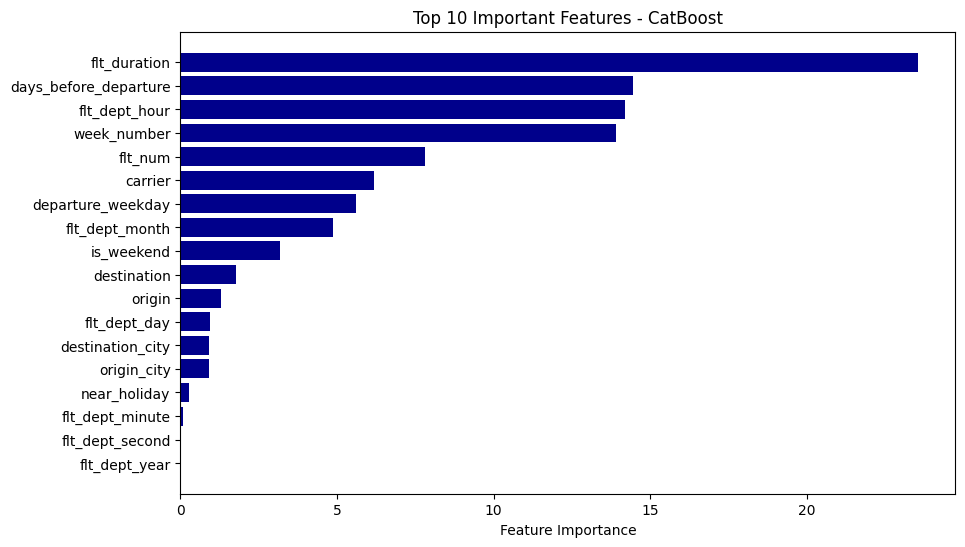

In [ ]:
# Get feature importance values from CatBoost
cat_importance = cat_model.get_feature_importance()
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(cat_importance)[::-1]

# Select top 10 important features
top_features = np.array(feature_names)[sorted_idx[:top_n]]
top_importance = cat_importance[sorted_idx[:top_n]]

# Plot feature importance for CatBoost
plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], top_importance[::-1], color='darkblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features - CatBoost")
plt.show()


#### Linear Regression

In [ ]:

# ✅ Feature Scaling (Important for Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Initialize & Train Linear Regression Model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_scaled, y_train)

# ✅ Predictions
y_pred = linear_reg_model.predict(X_test_scaled)

# ✅ Model Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 📊 Print Model Performance
print(f"📊 **Linear Regression Model Performance:**")
print(f"  - Mean Absolute Error (MAE): {mae:.2f}")
print(f"  - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"  - R² Score: {r2:.4f}")

📊 **Linear Regression Model Performance:**
  - Mean Absolute Error (MAE): 259.27
  - Root Mean Squared Error (RMSE): 455.90
  - R² Score: 0.2134


In [ ]:
mape_value = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_value:.2f}%")

MAPE: 40.72%


Here we can see that Linear Regression is performing the worst

### With Hyper Parameter Tuning

#### Random Forrest Hyper

In [ ]:
def hyperparameter_tuning(model, param_grid, X_train, y_train, cv=3, n_iter=25):
    """
    Optimized hyperparameter tuning using RandomizedSearchCV with tqdm progress tracking.

    Parameters:
    - model: ML model (RandomForestRegressor, XGBRegressor, CatBoostRegressor)
    - param_grid: Dictionary of hyperparameters
    - X_train: Training features
    - y_train: Training labels
    - cv: Cross-validation folds (default=3 for speed)
    - n_iter: Number of random searches (default=25 for efficiency)

    Returns:
    - best_model: Tuned model with best hyperparameters
    - best_params: Best hyperparameter set
    """

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='neg_mean_absolute_error',
        cv=cv,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    with tqdm(total=n_iter, desc="Hyperparameter Tuning Progress") as pbar:
        random_search.fit(X_train, y_train)
        pbar.update(n_iter)

    # Best parameters & best model
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_

    print(f"\nBest Parameters: {best_params}")
    return best_model, best_params


In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a trained model on the test dataset.

    Parameters:
    - model: Trained model.
    - X_test, y_test: Test data.

    Returns:
    - Prints evaluation metrics (MAE, RMSE, R²) for test set only.
    """

    # Predict on Test Set
    test_preds = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, test_preds)
    rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
    r2_test = r2_score(y_test, test_preds)

    print("\n Model Evaluation Results (Test Set Only):")
    print(f" Test Set → MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R²: {r2_test:.4f}")

    return test_preds


In [ ]:
rf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model_hyp = RandomForestRegressor(random_state=42)
best_rf, best_rf_params = hyperparameter_tuning(rf_model_hyp, rf_params, X_train, y_train)


Hyperparameter Tuning Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Hyperparameter Tuning Progress: 100%|██████████| 25/25 [3:37:20<00:00, 521.60s/it]


Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}


In [ ]:
rf_test_preds = evaluate_model(best_rf, X_test, y_test)


 Model Evaluation Results (Test Set Only):
 Test Set → MAE: 45.68, RMSE: 167.95, R²: 0.8932


In [ ]:

# Save the trained model
joblib.dump(best_rf, 'random_forest_fare_prediction_take_1_with_hyperTuning_best.pkl')
print("Model saved successfully!")


Model saved successfully!


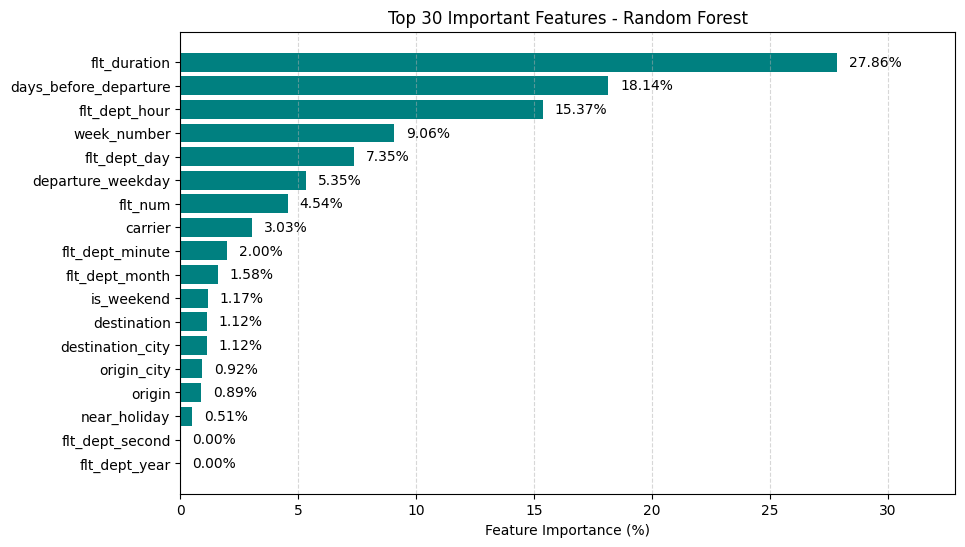

In [ ]:
# Get feature importance from the trained Random Forest model
feature_importance = best_rf.feature_importances_
feature_names = X_train.columns

# Sort feature importance values in descending order
sorted_idx = np.argsort(feature_importance)[::-1]

# Select top N important features
top_n = 30
top_features = np.array(feature_names)[sorted_idx[:top_n]]
top_importance = feature_importance[sorted_idx[:top_n]]

# Convert feature importance to percentage
top_importance_percentage = (top_importance / np.sum(top_importance)) * 100

# Plot feature importance
plt.figure(figsize=(10, 6))
bars = plt.barh(top_features[::-1], top_importance_percentage[::-1], color='teal')

# Add labels at the end of bars
for bar, value in zip(bars, top_importance_percentage[::-1]):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f"{value:.2f}%", ha='left', va='center', fontsize=10)

plt.xlabel("Feature Importance (%)")
plt.title("Top 30 Important Features - Random Forest")
plt.xlim(0, max(top_importance_percentage) + 5)  # Adjust X-axis limit for better spacing
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


In [1]:


def mean_absolute_percentage_error(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE)

    Parameters:
    y_true: array-like, actual values
    y_pred: array-like, predicted values

    Returns:
    float: MAPE value
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


In [ ]:
mape_value = mean_absolute_percentage_error(y_test, rf_test_preds)
print(f"MAPE: {mape_value:.2f}%")


MAPE: 5.74%


#### XgBoost Hyper

In [ ]:
xgboost_params = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds (not too high for efficiency)
    'learning_rate': [0.01, 0.05, 0.1],  # Lower values prevent overfitting
    'max_depth': [3, 5, 7],  # Smaller depth to avoid overfitting
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    'subsample': [0.7, 0.8, 0.9],  # Fraction of samples used per tree
    'colsample_bytree': [0.7, 0.8, 1.0],  # Fraction of features used per tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required for a split
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization (lasso)
    'reg_lambda': [0.1, 1, 10],  # L2 regularization (ridge)
}


In [ ]:
# Initialize XGBoost Model
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Suitable for regression tasks
    eval_metric='rmse',  # Use RMSE as the evaluation metric
    random_state=42,
    verbosity=1  # Show some progress output
)

# Perform Hyperparameter Tuning
best_xgb_model, best_xgb_params = hyperparameter_tuning(xgb_model, xgboost_params, X_train, y_train, cv=3, n_iter=20)

# Print Best Parameters
print("\n🚀 Best Parameters for XGBoost:")
print(best_xgb_params)


Hyperparameter Tuning Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Hyperparameter Tuning Progress: 100%|██████████| 20/20 [03:42<00:00, 11.12s/it]


Best Parameters: {'subsample': 0.7, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}

🚀 Best Parameters for XGBoost:
{'subsample': 0.7, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}


In [ ]:
xg_test_preds = evaluate_model(best_xgb_model, X_test, y_test)


 Model Evaluation Results (Test Set Only):
 Test Set → MAE: 122.56, RMSE: 232.69, R²: 0.7951


In [ ]:
mape_value = mean_absolute_percentage_error(y_test, xg_test_preds)
print(f"MAPE: {mape_value:.2f}%")


MAPE: 17.99%


In [ ]:
# Save the trained model
joblib.dump(best_xgb_model, 'XgB_fare_prediction_take_1_with_hyperTuning.pkl')
print("Model saved successfully!")


Model saved successfully!


#### CatBoost Hyper

In [ ]:
features_not_required = ['flt_arrival_local_time',
       'flt_departure_gmt', 'flt_arrival_gmt', 'observation_date', 'flt_departure_dt',
                        'flt_departure_local_time']

X = merged_df[[col for col in merged_df.columns if col not in features_not_required]]
y = merged_df[['total_fare']]
X = X[[col for col in X.columns if col!='total_fare']]

In [ ]:
X = X.fillna(0)

In [ ]:


# Bin the target variable (fare price) into 10 quantiles for stratified sampling
y = y.values.ravel()  # OR y = y.squeeze()

# Now apply stratified binning
y_binned = pd.qcut(y, q=10, labels=False, duplicates='drop')

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_binned, random_state=42
)


In [ ]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Categorical Features:", categorical_features)

Categorical Features: ['origin', 'destination', 'carrier', 'origin_city', 'destination_city', 'departure_weekday']


In [ ]:
catboost_params = {
    'iterations': [100, 200, 300],  # Fewer iterations for faster tuning
    'learning_rate': [0.01, 0.05, 0.1],  # Small to moderate learning rates
    'depth': [4, 6, 8],  # Lower depth to prevent overfitting
    'l2_leaf_reg': [1, 3, 5],  # Regularization strength
    'border_count': [32, 64, 128],  # Number of splits in feature binarization
    'bagging_temperature': [0.5, 1.0, 1.5],  # Controls randomness
    'random_strength': [1, 5, 10],  # Weight of random noise
    'grow_policy': ['Depthwise', 'SymmetricTree'],  # Growth policy for trees
    'boosting_type': ['Plain', 'Ordered']  # Plain for speed, Ordered for smaller datasets
}


In [ ]:

# Initialize CatBoost Model
cat_model = CatBoostRegressor(
    loss_function='RMSE',  # Regression task
    cat_features=categorical_features,  # Let CatBoost handle categorical features
    verbose=100,
    random_seed=42
)

# Perform Hyperparameter Tuning
best_cat_model, best_cat_params = hyperparameter_tuning(cat_model, catboost_params, X_train, y_train, cv=3, n_iter=20)

# Print Best Parameters
print("\n🚀 Best Parameters for CatBoost:")
print(best_cat_params)


Hyperparameter Tuning Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
0:	learn: 489.9286858	total: 949ms	remaining: 4m 43s
0:	learn: 489.3786671	total: 1.24s	remaining: 6m 12s
0:	learn: 492.8032278	total: 1.62s	remaining: 8m 5s
0:	learn: 502.0616630	total: 2.73s	remaining: 9m 3s
0:	learn: 501.1678772	total: 3.37s	remaining: 11m 10s
0:	learn: 504.8187606	total: 3.43s	remaining: 11m 22s
0:	learn: 512.7414502	total: 3.15s	remaining: 10m 26s
0:	learn: 512.0001030	total: 3.75s	remaining: 12m 26s
100:	learn: 283.6770015	total: 3m 32s	remaining: 6m 58s
100:	learn: 280.9737324	total: 3m 37s	remaining: 7m 9s
100:	learn: 281.0324111	total: 3m 41s	remaining: 7m 15s
100:	learn: 378.7782981	total: 3m 45s	remaining: 3m 40s
100:	learn: 376.5965451	total: 3m 47s	remaining: 3m 42s
100:	learn: 305.3889624	total: 5m 39s	remaining: 5m 32s
100:	learn: 303.2404791	total: 5m 48s	remaining: 5m 41s
100:	learn: 305.0283011	total: 5m 46s	remaining: 5m 39s
200:	learn: 263.8740135	total: 7m 28s	remaining: 3m 41s
200:	learn

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/py310/lib/python3.10/site-packages/catboost/core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
  File "/opt/anaconda3/envs/py310/lib/python3.10

0:	learn: 490.0745937	total: 547ms	remaining: 2m 43s
100:	learn: 281.2075217	total: 43.4s	remaining: 1m 25s
200:	learn: 261.1022238	total: 1m 28s	remaining: 43.5s


Hyperparameter Tuning Progress: 100%|██████████| 20/20 [43:29<00:00, 130.48s/it]

299:	learn: 249.3437504	total: 2m 12s	remaining: 0us

Best Parameters: {'random_strength': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'grow_policy': 'SymmetricTree', 'depth': 8, 'border_count': 32, 'boosting_type': 'Plain', 'bagging_temperature': 0.5}

🚀 Best Parameters for CatBoost:
{'random_strength': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'grow_policy': 'SymmetricTree', 'depth': 8, 'border_count': 32, 'boosting_type': 'Plain', 'bagging_temperature': 0.5}


In [ ]:
Cat_test_preds = evaluate_model(best_cat_model, X_test, y_test)


 Model Evaluation Results (Test Set Only):
 Test Set → MAE: 132.98, RMSE: 250.50, R²: 0.7625


In [ ]:
mape_value = mean_absolute_percentage_error(y_test, Cat_test_preds)
print(f"MAPE: {mape_value:.2f}%")


MAPE: 19.34%


In [ ]:
# Save the trained model
joblib.dump(best_cat_model, 'CatB_fare_prediction_take_1_with_hyperTuning.pkl')
print("Model saved successfully!")


Model saved successfully!


Selecting Random Forrest model with Hyper Tuning

## Test Set

In [ ]:
test_fares_df = pd.read_csv('/Users/deepeshdwivedi/Documents/personal docs/United Airlines/test/test_fares_data.csv',index_col=0)
test_fares_df.head()

,origin,destination,carrier,flt_num,flt_departure_dt,observation_date,origin_city,destination_city
1,Airport4,Airport43,L2,7465,1/1/2019,11/27/2018,City4,City39
2,Airport4,Airport43,L2,7067,1/1/2019,11/27/2018,City4,City39
3,Airport4,Airport43,L2,1232,1/1/2019,11/27/2018,City4,City39
4,Airport43,Airport4,L1,17783,1/3/2019,11/29/2018,City39,City4
5,Airport43,Airport4,L1,5823,1/3/2019,11/29/2018,City39,City4


In [ ]:
test_schedule_df = pd.read_csv('/Users/deepeshdwivedi/Documents/personal docs/United Airlines/test/test_schedules.csv',index_col=0)
test_schedule_df.head()

,carrier,flt_num,origin,destination,flt_departure_dt,flt_departure_local_time,flt_arrival_local_time,flt_departure_gmt,flt_arrival_gmt
1,L1,3437,Airport26,Airport30,2019-01-01,2019-01-01 18:28:00.0,2019-01-01 19:49:00.0,2019-01-02 00:28:00.0,2019-01-02 03:49:00.0
2,L1,7760,Airport26,Airport30,2019-01-01,2019-01-01 07:50:00.0,2019-01-01 09:12:00.0,2019-01-01 13:50:00.0,2019-01-01 17:12:00.0
3,L1,1609,Airport26,Airport30,2019-01-01,2019-01-01 11:55:00.0,2019-01-01 13:19:00.0,2019-01-01 17:55:00.0,2019-01-01 21:19:00.0
4,L1,1487,Airport26,Airport30,2019-01-01,2019-01-01 14:20:00.0,2019-01-01 15:41:00.0,2019-01-01 20:20:00.0,2019-01-01 23:41:00.0
5,L1,5701,Airport26,Airport30,2019-01-01,2019-01-01 22:05:00.0,2019-01-01 23:26:00.0,2019-01-02 04:05:00.0,2019-01-02 07:26:00.0


In [ ]:
# Ensure datetime formats are consistent before merging
test_fares_df['flt_departure_dt'] = pd.to_datetime(test_fares_df['flt_departure_dt'])
test_schedule_df['flt_departure_dt'] = pd.to_datetime(test_schedule_df['flt_departure_dt'])

# Perform a Many-to-One Merge on all columns
merged_df_test = test_fares_df.merge(
    test_schedule_df,
    on=['carrier', 'flt_num', 'origin', 'destination', 'flt_departure_dt'],
    how='left'  # Left join to keep all rows from `train_fares_df`
)

merged_df_test.head()


,origin,destination,carrier,flt_num,flt_departure_dt,observation_date,origin_city,destination_city,flt_departure_local_time,flt_arrival_local_time,flt_departure_gmt,flt_arrival_gmt
0,Airport4,Airport43,L2,7465,2019-01-01,11/27/2018,City4,City39,2019-01-01 08:04:00.0,2019-01-01 10:49:00.0,2019-01-01 14:04:00.0,2019-01-01 16:49:00.0
1,Airport4,Airport43,L2,7067,2019-01-01,11/27/2018,City4,City39,2019-01-01 13:17:00.0,2019-01-01 16:00:00.0,2019-01-01 19:17:00.0,2019-01-01 22:00:00.0
2,Airport4,Airport43,L2,1232,2019-01-01,11/27/2018,City4,City39,2019-01-01 18:40:00.0,2019-01-01 21:25:00.0,2019-01-02 00:40:00.0,2019-01-02 03:25:00.0
3,Airport43,Airport4,L1,17783,2019-01-03,11/29/2018,City39,City4,2019-01-03 07:48:00.0,2019-01-03 10:50:00.0,2019-01-03 13:48:00.0,2019-01-03 16:50:00.0
4,Airport43,Airport4,L1,5823,2019-01-03,11/29/2018,City39,City4,2019-01-03 15:55:00.0,2019-01-03 18:49:00.0,2019-01-03 21:55:00.0,2019-01-04 00:49:00.0


In [ ]:
merged_df_test['flt_departure_local_time'] = pd.to_datetime(merged_df_test['flt_departure_local_time'])
merged_df_test['flt_dept_day'] = merged_df_test.flt_departure_dt.dt.day
merged_df_test['flt_dept_month'] = merged_df_test.flt_departure_dt.dt.month
merged_df_test['flt_dept_year'] = merged_df_test.flt_departure_dt.dt.year
merged_df_test['flt_dept_hour'] = merged_df_test.flt_departure_local_time.dt.hour
merged_df_test['flt_dept_minute'] = merged_df_test.flt_departure_local_time.dt.minute
merged_df_test['flt_dept_second'] = merged_df_test.flt_departure_local_time.dt.second

In [ ]:
merged_df_test['flt_departure_dt'] = pd.to_datetime(merged_df_test['flt_departure_dt'])

# Extract Weekday Name
merged_df_test['departure_weekday'] = merged_df_test['flt_departure_dt'].dt.day_name()

# Create a Weekend Column (1 = Weekend, 0 = Weekday)
merged_df_test['is_weekend'] = merged_df_test['flt_departure_dt'].dt.weekday.isin([4, 5, 6]).astype(int)

# Display updated dataframe
merged_df_test.head()


,origin,destination,carrier,flt_num,flt_departure_dt,observation_date,origin_city,destination_city,flt_departure_local_time,flt_arrival_local_time,flt_departure_gmt,flt_arrival_gmt,flt_dept_day,flt_dept_month,flt_dept_year,flt_dept_hour,flt_dept_minute,flt_dept_second,departure_weekday,is_weekend
0,Airport4,Airport43,L2,7465,2019-01-01,11/27/2018,City4,City39,2019-01-01 08:04:00,2019-01-01 10:49:00.0,2019-01-01 14:04:00.0,2019-01-01 16:49:00.0,1,1,2019,8.0,4.0,0.0,Tuesday,0
1,Airport4,Airport43,L2,7067,2019-01-01,11/27/2018,City4,City39,2019-01-01 13:17:00,2019-01-01 16:00:00.0,2019-01-01 19:17:00.0,2019-01-01 22:00:00.0,1,1,2019,13.0,17.0,0.0,Tuesday,0
2,Airport4,Airport43,L2,1232,2019-01-01,11/27/2018,City4,City39,2019-01-01 18:40:00,2019-01-01 21:25:00.0,2019-01-02 00:40:00.0,2019-01-02 03:25:00.0,1,1,2019,18.0,40.0,0.0,Tuesday,0
3,Airport43,Airport4,L1,17783,2019-01-03,11/29/2018,City39,City4,2019-01-03 07:48:00,2019-01-03 10:50:00.0,2019-01-03 13:48:00.0,2019-01-03 16:50:00.0,3,1,2019,7.0,48.0,0.0,Thursday,0
4,Airport43,Airport4,L1,5823,2019-01-03,11/29/2018,City39,City4,2019-01-03 15:55:00,2019-01-03 18:49:00.0,2019-01-03 21:55:00.0,2019-01-04 00:49:00.0,3,1,2019,15.0,55.0,0.0,Thursday,0


In [ ]:
merged_df_test['flt_arrival_gmt'] = pd.to_datetime(merged_df_test['flt_arrival_gmt'])
merged_df_test['flt_departure_gmt'] = pd.to_datetime(merged_df_test['flt_departure_gmt'])
merged_df_test['observation_date'] = pd.to_datetime(merged_df_test['observation_date'])
merged_df_test['flt_duration'] = (merged_df_test['flt_arrival_gmt'] - merged_df_test['flt_departure_gmt']).dt.seconds/3600

In [ ]:
# Define US Federal Holidays for 2018
cal = USFederalHolidayCalendar()
holidays = pd.to_datetime(cal.holidays(start='2017-11-01', end='2018-12-31'))

# Function to check if a date is within ±3 days of a holiday
def is_near_holiday(x):
    """
    Returns 1 if the given date is within 3 days before/after a US holiday, else 0.
    """
    for h_day in holidays:
        try:
            if abs((h_day - x).days) <= 7:  # Check if within 3 days of a holiday
                return 1  # Near holiday
        except TypeError:
            continue
    return 0  # Not near a holiday

# Apply function to create a boolean variable
merged_df_test['near_holiday'] = merged_df_test['flt_departure_dt'].apply(is_near_holiday)


In [ ]:
# Extract the week number (ISO Week Number: 1-52)
merged_df_test['week_number'] = merged_df_test['flt_departure_dt'].dt.isocalendar().week

In [ ]:
merged_df_test['days_before_departure'] = (merged_df_test['flt_departure_dt'] - merged_df_test['observation_date']).dt.days

In [ ]:
features_not_required = ['flt_arrival_local_time',
       'flt_departure_gmt', 'flt_arrival_gmt', 'observation_date', 'flt_departure_dt',
                        'flt_departure_local_time']

X = merged_df_test[[col for col in merged_df_test.columns if col not in features_not_required]]

In [ ]:
X.isna().sum()

origin                      0
destination                 0
carrier                     0
flt_num                     0
origin_city                 0
destination_city            0
flt_dept_day                0
flt_dept_month              0
flt_dept_year               0
flt_dept_hour            1555
flt_dept_minute          1555
flt_dept_second          1555
departure_weekday           0
is_weekend                  0
flt_duration             1555
near_holiday                0
week_number                 0
days_before_departure       0
dtype: int64

In [ ]:
X = X.fillna(0)

In [ ]:
# Load the Label Encoder from the saved file
with open("label_encoders.pkl", "rb") as file:
    label_encoders = pickle.load(file)

In [ ]:
print("Loaded Label Encoders:", label_encoders.keys())

Loaded Label Encoders: dict_keys(['origin', 'destination', 'origin_city', 'destination_city', 'carrier', 'departure_weekday'])


In [ ]:
label_encoders

{'origin': LabelEncoder(),
 'destination': LabelEncoder(),
 'origin_city': LabelEncoder(),
 'destination_city': LabelEncoder(),
 'carrier': LabelEncoder(),
 'departure_weekday': LabelEncoder()}

In [ ]:
categorical_columns = label_encoders.keys()

# Apply Label Encoding to each categorical column in the test set
for col in categorical_columns:
    if col in X_test.columns:
        # Transform using the previously trained encoder
        X[col] = label_encoders[col].transform(X[col])

In [ ]:
# Load the best RF Model
# Load the saved Random Forest model
best_rf_model = joblib.load("random_forest_fare_prediction_take_1_with_hyperTuning_best.pkl")

# Verify model loading
print("Loaded Random Forest Model:\n", best_rf_model)

Loaded Random Forest Model:
 RandomForestRegressor(bootstrap=False, min_samples_split=5, n_estimators=50,
                      random_state=42)


In [ ]:
y_preds = best_rf_model.predict(X)

In [ ]:
y_preds.shape

(29825,)

In [ ]:
X.shape

(29825, 18)

In [ ]:
test_fares_df['predicted_fares'] = y_preds

In [ ]:
test_fares_df.head()

,origin,destination,carrier,flt_num,flt_departure_dt,observation_date,origin_city,destination_city,predicted_fares
1,Airport4,Airport43,L2,7465,2019-01-01,11/27/2018,City4,City39,871.00
2,Airport4,Airport43,L2,7067,2019-01-01,11/27/2018,City4,City39,925.42
3,Airport4,Airport43,L2,1232,2019-01-01,11/27/2018,City4,City39,904.44
4,Airport43,Airport4,L1,17783,2019-01-03,11/29/2018,City39,City4,808.50
5,Airport43,Airport4,L1,5823,2019-01-03,11/29/2018,City39,City4,808.00


In [ ]:
test_fares_df.to_csv('test_fares_data_Deepesh_Dwivedi.csv')

## Appendix

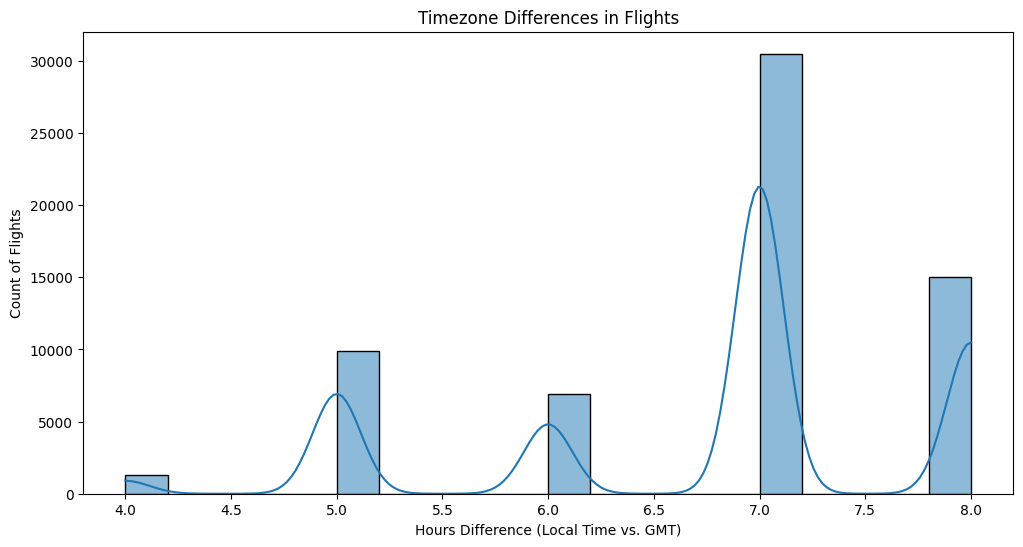

In [ ]:
train_schedules_df['timezone_difference'] = (train_schedules_df['flt_arrival_gmt'] - train_schedules_df['flt_arrival_local_time']).dt.total_seconds() / 3600

plt.figure(figsize=(12,6))
sns.histplot(train_schedules_df['timezone_difference'], bins=20, kde=True)
plt.title("Timezone Differences in Flights")
plt.xlabel("Hours Difference (Local Time vs. GMT)")
plt.ylabel("Count of Flights")
plt.show()


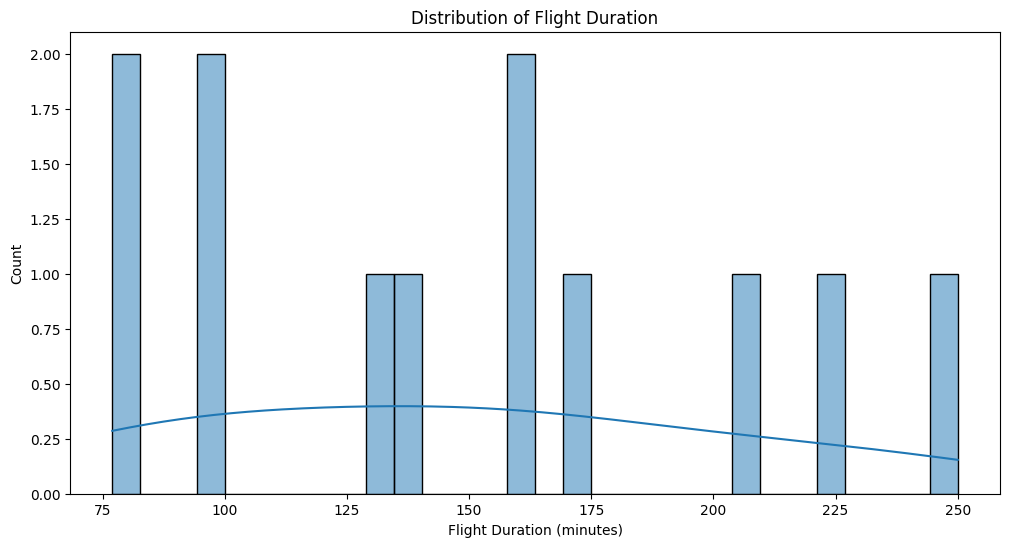

In [ ]:
train_schedules_df['flight_duration'] = (train_schedules_df['flt_arrival_gmt'] - train_schedules_df['flt_departure_gmt']).dt.total_seconds() / 60  # Convert to minutes

plt.figure(figsize=(12,6))
sns.histplot(train_schedules_df['flight_duration'], bins=30, kde=True)
plt.title("Distribution of Flight Duration")
plt.xlabel("Flight Duration (minutes)")
plt.ylabel("Count")
plt.show()


In [ ]:
# Convert to datetime format
train_schedules_df['flt_departure_local_time'] = pd.to_datetime(train_schedules_df['flt_departure_local_time'])
train_schedules_df['flt_departure_gmt'] = pd.to_datetime(train_schedules_df['flt_departure_gmt'])


# Calculate raw offset (time difference in hours)
train_schedules_df['timezone_offset_hours'] = (train_schedules_df['flt_departure_gmt'] - train_schedules_df['flt_departure_local_time']).dt.total_seconds() / 3600

# Determine whether local time is behind or ahead of GMT
train_schedules_df['timezone_offset_corrected'] = train_schedules_df.apply(
    lambda row: row['timezone_offset_hours'] if row['flt_departure_gmt'].date() >= row['flt_departure_local_time'].date()
    else -row['timezone_offset_hours'], axis=1
)

# Display results
print(train_schedules_df[['flt_departure_local_time', 'flt_departure_gmt', 'timezone_offset_hours', 'timezone_offset_corrected']])
print("Unique Time Zone Offsets (in UTC format):", train_schedules_df['timezone_offset_corrected'].unique())

      flt_departure_local_time   flt_departure_gmt  timezone_offset_hours  \
1          2018-02-01 18:43:00 2018-02-02 00:43:00                    6.0   
207        2018-07-01 16:02:00 2018-07-01 21:02:00                    5.0   
388        2018-07-01 20:05:00 2018-07-02 01:05:00                    5.0   
620        2018-08-01 20:34:00 2018-08-02 03:34:00                    7.0   
1729       2018-08-01 15:35:00 2018-08-01 22:35:00                    7.0   
2707       2018-12-01 10:15:00 2018-12-01 18:15:00                    8.0   
4255       2018-05-01 12:50:00 2018-05-01 18:50:00                    6.0   
10276      2018-03-01 18:40:00 2018-03-02 02:40:00                    8.0   
11353      2018-03-01 14:16:00 2018-03-01 22:16:00                    8.0   
14867      2018-03-01 20:00:00 2018-03-02 02:00:00                    6.0   
20032      2018-01-01 08:10:00 2018-01-01 14:10:00                    6.0   
21628      2018-05-01 16:05:00 2018-05-01 20:05:00                    4.0   

Since GMT is greater than Local Time, the dataset originates from a region behind UK time, meaning the Western Hemisphere. Given the presence of UTC-6, UTC-7, and UTC-8, the data is most likely from the United States, Canada, or Mexico. South America is unlikely because it does not have UTC-7 or UTC-8.